## Trying to convert HDDM model object to ArviZ

Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com

I tried to convert `HDDM` model object ot `Arviz`'s `InferenceData` so that we can use the statistical functions of `Arviz`, such as `loo`, `waic`, and `plot_ppc`.

Data used in this script: the example data from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html). 

Computing environment: a [HDDM docker image](https://hub.docker.com/r/hcp4715/hddm), tag: `hcp4715/hddm:arviz`.
 
Previously, I had an issue: `nan` was genrated when converting a Dataframe of point-wise likelihood to Xarray, see [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268). 

After looking into the `loglikelihood` generated from `pymc3` (through `bambi`), I found that the point-wise log likelihood has only three dimensions: chain, draw, and observations, which avoid the problem of unequal numbers of observations across conditions/subjects.

Also importantly, for hierarchical models, there are different ways for `loo`: leave-one-observation-out, or leave-one-group-out (or leave-one-subject-out in this case), see [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268) and [here](https://github.com/arviz-devs/arviz/issues/987#issuecomment-868980268) for more details.

In this script, I included two approaches for `loo`: leave one observation out and leave one subject-condition pair out.

I compared two models using `loo` and `waic` using both approaches: with or without `depends_on` argument.


In [1]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import sparse # test whether package `sparse` is installed; doesn't matter if not installed.

from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


The current HDDM version is:  0.8.0


In [2]:
# NOTE: I hacked the `post_pred_gen`, 
# more detals: https://groups.google.com/g/hddm-users/c/Is6AM7eN0fo
from post_pred_gen_redifined import _parents_to_random_posterior_sample
from post_pred_gen_redifined import _post_pred_generate
from post_pred_gen_redifined import post_pred_gen

## Loading data

The data is from `HDDM` package itself, but it was hidden somewhere:

In [3]:
# # find the directory of "cavanagh_theta_nn.csv"
# print(hddm.__file__)
# !head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

In [4]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
# data.head()

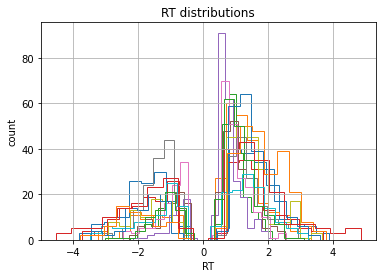

In [5]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

In [6]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

### Description of the issue

As we can see from the data structure, there are 14 participants (0 ~  13), and there are three conditions: LL, WL, and WW. The number of trials of each each condition of each participant is not equal. 

When calculating the point-wise likielihood, I calculated the pdf of each trial's data, condiitioned on the sample from posterior of all parameters. 

$$pdf_{wfpt}(rt_i | v, a, t, z, sv, st, sz) $$, where $pdf_{wfpt}$ pdf of $wfpt$, which is define by `HDDM`,  the $v, a, t, z, sv, st, sz$ are from each draw of posterior. 

The above code is suppose to get the value for log pointwise likelihood as below:

$$log[E_{postereior}(p(y_i | \theta))] $$

which is then used for `waic`:

$\widehat{elppd} = \sum_{i=1}^{n} log[E_{postereior}(p(y_i | \theta))] - k_{WAIC}$

where:

$k_{WAIC} = \sum_{i=1}^{n} var_{posterior}(log p(y_i | \theta))$.

$WAIC = -2 * \widehat{elppd}$


Therefore the unequal number of trials will results in uneuqal number of point-wise log likelihood value ($elppd$) for each condition. When converting the dataframe of $elppd$ to `Xarray` datasets, **with `subj_idx`, `stim`, `trial`, `draw`, and `chain` as dimensons**, `Xarray` force the length of `trial` to be the maximum number of trials and filled `nan` to those with smaller number of trials.

When I truncate the data so that all conditions had the same number of trials, there will be no `nan`.

In [7]:
# truncate the trials so that all conditions has the same number of trials
data['trial'] = data.groupby(['subj_idx', 'stim','conf']).cumcount()
min_trial_num = data.groupby(['subj_idx', 'stim', 'conf']).size().min()
data_trunc = data[data['trial']<=52].copy()

Check number of trials of each condition for each participant.

In [8]:
data_trunc.groupby(['subj_idx', 'stim', 'conf']).size()

subj_idx  stim  conf
0         LL    HC      53
          WL    LC      53
          WW    HC      53
1         LL    HC      53
          WL    LC      53
          WW    HC      53
2         LL    HC      53
          WL    LC      53
          WW    HC      53
3         LL    HC      53
          WL    LC      53
          WW    HC      53
4         LL    HC      53
          WL    LC      53
          WW    HC      53
5         LL    HC      53
          WL    LC      53
          WW    HC      53
6         LL    HC      53
          WL    LC      53
          WW    HC      53
7         LL    HC      53
          WL    LC      53
          WW    HC      53
8         LL    HC      53
          WL    LC      53
          WW    HC      53
9         LL    HC      53
          WL    LC      53
          WW    HC      53
10        LL    HC      53
          WL    LC      53
          WW    HC      53
11        LL    HC      53
          WL    LC      53
          WW    HC      53
12     

## Fitting a hierarchical model and convert

### Model specification
Here we used a model from the official tutorial:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

We used parallel processing by `p_tqdm`.

We will only use 1500 sample and burnin 500.

In [9]:
chains = 4
samples = 1500
burn = 500

# define a function to run model in parallel
def run_m1(id, df=None, samples=None, burn=None, save_name=None): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [10]:
# define a mode for calculating the point-wise log likelihood
# we can then use parallel processing for it
def calc_plld(m, observed=None, *argm):
    """
    m: HDDM model object, not a list
    observed: observed data from which the model was built
    """
    data_grouped = observed.groupby(['subj_idx', 'stim'])
    tmp_posterior = m.get_traces()
    # tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
    df_loglik = []
    
    for group_name, df_grouped in data_grouped:
        #print("sub: ", group_name[0])
        #print("stim: ", group_name[1])
        tmp_df =data_grouped.get_group(group_name)
        tmp_df = np.array(tmp_df['rt'])

        a_colname = "a_subj." + str(group_name[0])
        t_colname = "t_subj." + str(group_name[0])
        v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

        for index, row in tmp_posterior.iterrows():
            tmp_a = row[a_colname]
            tmp_t = row[t_colname]
            tmp_v = row[v_colname]

            # Here we start using the pdf func of wfpt to calculate the likelihood
            tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                   v = np.array(tmp_v),
                                   a = np.array(tmp_a), 
                                   t = np.array(tmp_t),
                                   p_outlier = 0.05,
                                   sv = 0,
                                   z = 0.5,
                                   sz = 0,
                                   st = 0)

            if np.sum(tmp_lik == 0.0) > 0:
                # print('Likelihood is zero, converted to 1/1e3 !\n')
                tmp_lik[tmp_lik == 0.0] = 1/1e300
                
            elif np.sum(np.isnan(tmp_lik))  > 0:
                print('NAN in the likelihood, check the data !')
                break

            obs = np.log(tmp_lik)

            if np.sum(np.isinf(obs)) > 0:
                print('Correction does not work!!!\n')

            tmp_df_pll = pd.DataFrame({'obs': obs,
                                       'draw': index,
                                       'subj_idx': group_name[0],
                                       'stim': group_name[1]})
            tmp_df_pll['trial'] = tmp_df_pll.groupby(['draw', 'subj_idx', 'stim']).cumcount()
            df_loglik.append(tmp_df_pll)
        
    df_loglik = pd.concat(df_loglik)
            
    return df_loglik

Here we define a function to run the model, get posterior, generate posterior predictive, and calculate the point-wise log likelihood. The steps inside can be executed separately too.

In [11]:
# we can put all the above in a function to run all the coverting
# note: this function is specified for  this model
def model_fitting(df, model_name='df_m', **kwargs):
    """
    from data to arviz data
    """
    import arviz as az
    import numpy as np
    import pandas as pd
    import xarray as xr
    
    import hddm
    import kabuki
    
    from p_tqdm import p_map
    from functools import partial
    
    chains = 4
    samples = 500
    burn = 200
    model_name= model_name
    
    # step 1: run model, list    
    ms = p_map(partial(run_m1, df=df, samples=samples, 
                       burn=burn, save_name=model_name),
               range(4))
    
    # step 2: get ppc, list
    ppc_list = p_map(partial(post_pred_gen, 
                             samples = samples - burn),
                     ms)
    
    # step 3: get point-wise likelihoods, list
    loglik_list = p_map(partial(calc_plld, observed=df), ms)
    
#     # step 4: Xarray
#     # 4.1 observed
#     obs_data_tmp = df.copy()
# #     obs_data_tmp['trial'] = obs_data_tmp.groupby(['subj_idx', 'stim']).cumcount()
# #     obs_data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
# #     obs_data_tmp = obs_data_tmp.set_index(["subj_idx", "stim", 'trial'])
# #     xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)
#     obs_data_tmp = obs_data_tmp.reset_index()
#     obs_data_tmp = obs_data_tmp.rename(columns={'index':'rt_dim0'})
#     obs_data_tmp.drop(['subj_idx','stim','trial', 'theta','dbs','conf'], axis=1, inplace=True)
#     obs_data_tmp = obs_data_tmp.set_index(["rt_dim0"])
#     xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)
    
    # 4.2 posterior
    df_traces = []
    for jj in range(len(ms)):
        m = ms[jj]
        trace_tmp = m.get_traces()
        trace_tmp['chain'] = jj
        trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
#         print('chain', jj, trace_tmp.shape)
        df_traces.append(trace_tmp)
    df_traces = pd.concat(df_traces)
#     df_traces = df_traces.set_index(["chain", "draw"])
#     xdata_posterior = xr.Dataset.from_dataframe(df_traces)
    
    # 4.3 posterior predictive
    df_ppc = []
    for kk in range(len(ppc_list)):
        ppc_tmp = ppc_list[kk]
        ppc_tmp.reset_index(inplace=True)
        ppc_tmp['chain'] = kk
        ppc_tmp.rename(columns={'sample':'draw',
                                'level_2':'trial'}, inplace=True)
#         print('\nchain', kk, ppc_tmp.shape)
        ppc_tmp[['stim', 'subj_idx']] = ppc_tmp['node'].str.split(pat='\.', expand=True)
        # extract the stim string between "(" and ")"
        ppc_tmp['stim'] = ppc_tmp['stim'].str.extract('.*\((.*)\).*')
        ppc_tmp.drop('node', axis=1, inplace=True)
        df_ppc.append(ppc_tmp)
        
    df_ppc = pd.concat(df_ppc)
#     df_ppc = df_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
#     xdata_post_pred = xr.Dataset.from_dataframe(df_ppc)
#     df_ppc['rt_dim0'] = df_ppc.groupby(['chain', 'draw']).cumcount()
#     df_ppc.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
#     df_ppc = df_ppc.set_index(["chain", "draw", 'rt_dim0'])
#     xdata_post_pred = xr.Dataset.from_dataframe(df_ppc)
#     xdata_post_pred
    
    # 4.4 point-wise log lik
    for chain in range(len(loglik_list)):
        loglik_list[chain]['chain'] = chain   
    df_loglik = pd.concat(loglik_list)

#     if level == 'obs':
#         df_loglik['rt_dim0'] = df_loglik.groupby(['chain', 'draw']).cumcount()
#         df_loglik.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
#         df_loglik = df_loglik.set_index(["chain", "draw",'rt_dim0'])
#         xdata_loglik = xr.Dataset.from_dataframe(df_loglik)   
#     elif level == 'subj':
#         df_loglik = df_loglik.copy()
#         df_loglik.drop(['trial'], axis=1, inplace=True)
#         df_loglik = df_loglik.groupby(['chain', 'draw', 'subj_idx', 'stim']).sum()
#         xdata_loglik = xr.Dataset.from_dataframe(df_loglik)
        
#     InfData = az.InferenceData(posterior=xdata_posterior, 
#                                observed_data=xdata_observed,
#                                posterior_predictive=xdata_post_pred,
#                                log_likelihood = xdata_loglik)

    return ms, df_traces, df_ppc, df_loglik

In [12]:
def to_infdata(df=None, df_traces=None, df_ppc=None, df_loglik=None, level="obs"):
    obs_data_tmp = df.copy()
    df_traces_tmp = df_traces.copy()
    df_ppc_tmp = df_ppc.copy()
    df_loglik_tmp = df_loglik.copy()
    
    # 4.1 observed
    obs_data_tmp = obs_data_tmp.reset_index()
    obs_data_tmp = obs_data_tmp.rename(columns={'index':'rt_dim0'})
    # obs_data_tmp['rt_dim0'] = obs_data_tmp.cumcount()
    obs_data_tmp.drop(['subj_idx','stim','trial', 'theta','dbs','conf'], axis=1, inplace=True)
    obs_data_tmp = obs_data_tmp.set_index(["rt_dim0"])
    xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)

    # 4.2 posterior
    df_traces_tmp = df_traces_tmp.set_index(["chain", "draw"])
    xdata_posterior = xr.Dataset.from_dataframe(df_traces_tmp)

    # 4.3 posterior predictive
    df_ppc_tmp['rt_dim0'] = df_ppc_tmp.groupby(['chain', 'draw']).cumcount()
    df_ppc_tmp.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
    df_ppc_tmp = df_ppc_tmp.set_index(["chain", "draw", 'rt_dim0'])
    xdata_post_pred = xr.Dataset.from_dataframe(df_ppc_tmp)
    xdata_post_pred
    
    # 4.4 point-wise log lik
    if level == 'obs':
        df_loglik_tmp['rt_dim0'] = df_loglik_tmp.groupby(['chain', 'draw']).cumcount()
        df_loglik_tmp.drop(['subj_idx','stim','trial'], axis=1, inplace=True)
        df_loglik_tmp = df_loglik_tmp.set_index(["chain", "draw",'rt_dim0'])
        xdata_loglik = xr.Dataset.from_dataframe(df_loglik_tmp)       
    elif level == 'subj':
        df_loglik_tmp = df_loglik.copy()
        df_loglik_tmp.drop(['trial'], axis=1, inplace=True)
        df_loglik_tmp = df_loglik_tmp.groupby(['chain', 'draw', 'subj_idx', 'stim']).sum()
        xdata_loglik = xr.Dataset.from_dataframe(df_loglik_tmp)
        
    InfData = az.InferenceData(posterior=xdata_posterior, 
                               observed_data=xdata_observed,
                               posterior_predictive=xdata_post_pred,
                               log_likelihood = xdata_loglik)

    return InfData

In [13]:
ms, df_traces, df_ppc, df_loglik = model_fitting(df=data, model_name='df_m')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -----------------56%-                 ] 280 of 500 complete in 32.7 sec                 1%                  ] 6 of 500 complete in 0.6 sec[                  1%                  ] 6 of 500 complete in 0.6 sec[                  1%                  ] 6 of 500 complete in 0.6 sec[                  2%                  ] 11 of 500 complete in 1.1 sec[                  2%                  ] 11 of 500 complete in 1.2 sec[                  2%                  ] 10 of 500 complete in 1.1 sec[                  2%                  ] 11 of 500 complete in 1.2 sec[-                 3%                  ] 16 of 500 complete in 1.7 sec[-                 3%                  ] 16 of 500 complete in 1.8 sec[-                 3%                  ] 15 of 500 complete in 1.7 sec[-                 3%                  ] 16 of 500 complete in 1.8 sec[-                 4%                  ] 21 of 500 complete in 2.3 sec[-                 4%                  ] 21 of 500 complete in 2.4 sec[-                 4%  

 [---               9%                  ] 4 of 42 complete in 3.6 sec  [---               9%                  ] 4 of 42 complete in 3.6 sec[---               9%                  ] 4 of 42 complete in 3.6 sec[---               9%                  ] 4 of 42 complete in 3.6 sec[----             11%                  ] 5 of 42 complete in 7.2 sec[----             11%                  ] 5 of 42 complete in 7.3 sec[----             11%                  ] 5 of 42 complete in 7.3 sec[----             11%                  ] 5 of 42 complete in 7.3 sec[-----            14%                  ] 6 of 42 complete in 10.6 sec[-----            14%                  ] 6 of 42 complete in 10.6 sec[-----            14%                  ] 6 of 42 complete in 10.6 sec[-----            14%                  ] 6 of 42 complete in 10.6 sec[------           16%                  ] 7 of 42 complete in 14.3 sec[------           16%                  ] 7 of 42 complete in 14.3 sec[------           16%                  

In [14]:
InfData_1 = to_infdata(df=data, df_traces=df_traces, 
                       df_ppc=df_ppc, df_loglik=df_loglik, 
                       level="obs")

In [15]:
InfData_2 = to_infdata(df=data, df_traces=df_traces, 
                       df_ppc=df_ppc, df_loglik=df_loglik, 
                       level="subj")

In [16]:
InfData_1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [17]:
InfData_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [18]:
az.loo(InfData_1)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


Computed from 1200 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -17997.04  2821.69
p_loo     8862.36        -

There has been a warning during the calculation. Please check the results.

In [19]:
az.waic(InfData_1)

Computed from 1200 by 3988 log-likelihood matrix

          Estimate       SE
elpd_waic -595884.73  214180.50
p_waic    586750.05        -

There has been a warning during the calculation. Please check the results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb1aae20d0>,
      dtype=object)

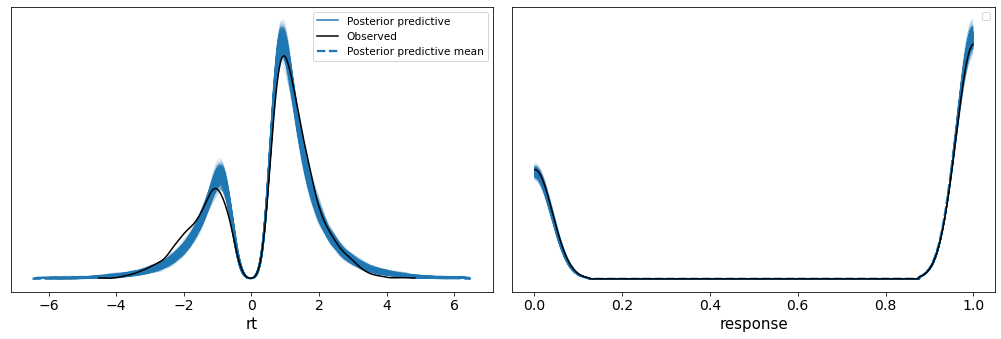

In [20]:
az.plot_ppc(InfData_1)

In [21]:
az.loo(InfData_2)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:908: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa


Computed from 1200 by 42 log-likelihood matrix

         Estimate       SE
elpd_loo -21065.38  4494.38
p_loo    11908.31        -

There has been a warning during the calculation. Please check the results.

In [22]:
az.waic(InfData_2)

Computed from 1200 by 42 log-likelihood matrix

          Estimate       SE
elpd_waic -737950.52  334155.39
p_waic    728793.46        -

There has been a warning during the calculation. Please check the results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb1bb89dd0>,
      dtype=object)

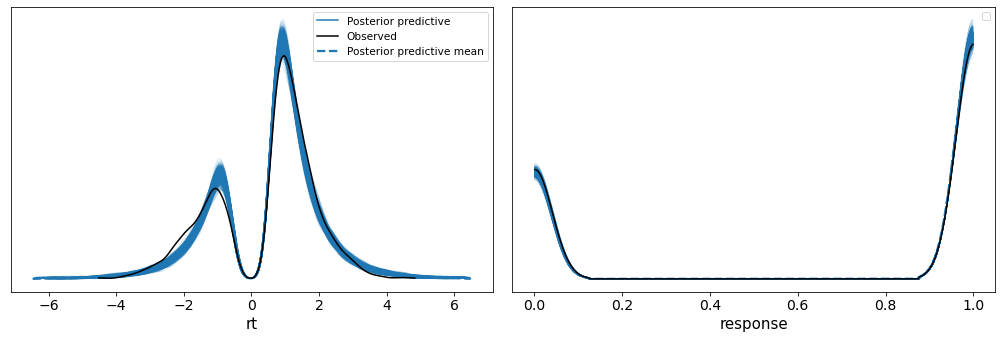

In [23]:
az.plot_ppc(InfData_2)

In [ ]:
az.plot_trace(InfData_2)

In [ ]:
az.plot_forest(InfData_1)

In [ ]:
# from Jinbiao
import threading
def map_reduce(func):
    prorgress = [0] * 4
    for i in range (4):
        th = threading.Thread(target=func, args=(i, progress))
        th.start()
        
import time
import random
def func(index, progress):
    for i in range(5):
        time.sleep(random, random())
        progress[index] += 1
        print(progress.end='\r')
        
map_reduce(func)

#### 4.1 Let's see what the problem

Here we can see that `nan` issue occur even when we try to convert observed data.

In [12]:
obs_data_tmp = data.copy()
obs_data_tmp['trial'] = obs_data_tmp.groupby(['subj_idx', 'stim']).cumcount()
obs_data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
obs_data_tmp = obs_data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(obs_data_tmp)

In [13]:
xdata_observed

<xarray.Dataset>
Dimensions:   (stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (subj_idx, stim, trial) float64 1.21 2.0 1.72 1.72 ... nan nan nan
    response  (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan

####  4.2 compare truncated and not truncated data

In [14]:
ms_2, df_traces_2, df_ppc_2, InfData_2 = model_to_arviz(data_trunc, model_name='df_trunc_m')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 9 of 1500 complete in 1.0 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 13 of 1500 complete in 1.5 sec[                  1%                  ] 16 of 1500 complete in 1.7 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.9 sec[                  1%                  ] 18 of 1500 complete in 2.1 sec[                  1%                  ] 21 of 1500 complete in 2.3 sec[         

 [---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 13.0 sec[---               9%                  ] 4 of 42 complete in 13.0 sec[----             11%                  ] 5 of 42 complete in 25.9 sec[----             11%                  ] 5 of 42 complete in 26.0 sec[----             11%                  ] 5 of 42 complete in 26.0 sec[----             11%                  ] 5 of 42 complete in 26.2 sec[-----            14%                  ] 6 of 42 complete in 38.3 sec[-----            14%                  ] 6 of 42 complete in 38.5 sec[-----            14%                  ] 6 of 42 complete in 38.5 sec[-----            14%                  ] 6 of 42 complete in 38.6 sec[------           16%                  ] 7 of 42 complete in 52.0 sec[------           16%                  ] 7 of 42 complete in 52.0 sec[------           16%            


start to convert to Inference data.



In [15]:
az.waic(InfData_2)

Computed from 4000 by 2226 log-likelihood matrix

          Estimate       SE
elpd_waic -400070.72  148341.26
p_waic    396913.82        -

There has been a warning during the calculation. Please check the results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe577910810>,
      dtype=object)

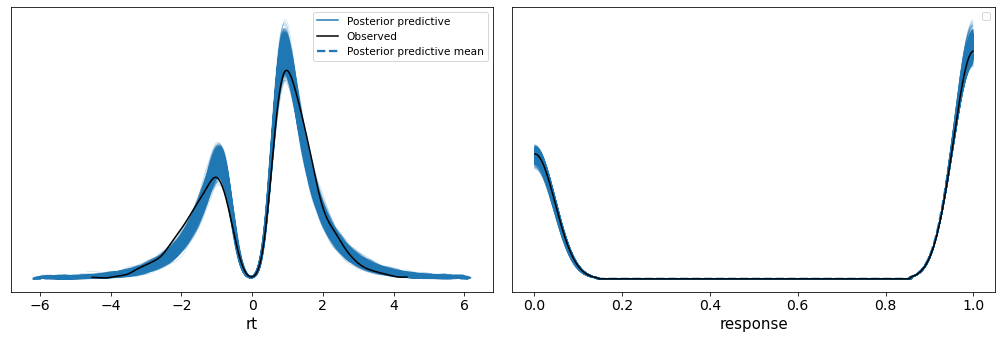

In [16]:
az.plot_ppc(InfData_2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe446161ad0>,
      dtype=object)

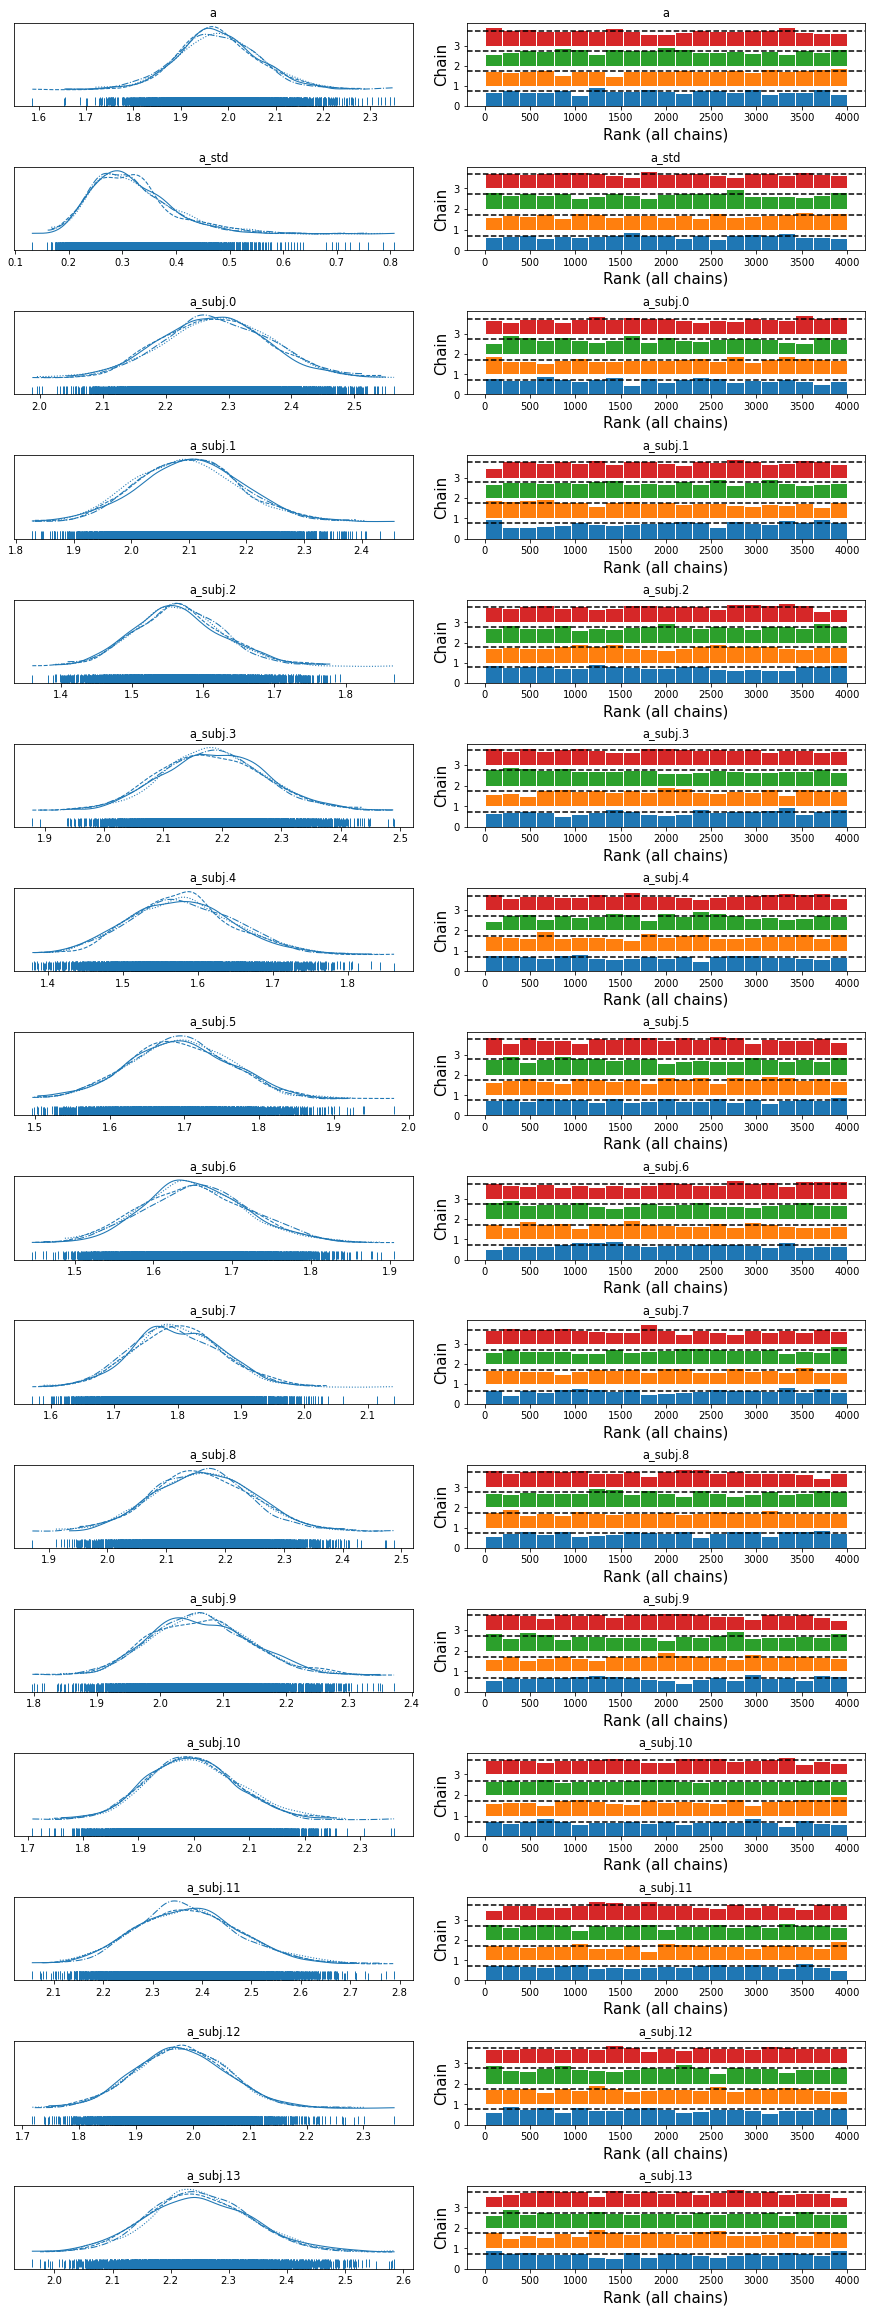

In [17]:
az.plot_trace(InfData_2, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

In [19]:
ms_1, df_traces_1, df_ppc_1, InfData_1 = model_to_arviz(data, model_name='df_m')

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 10 of 1500 complete in 1.1 sec[                  0%                  ] 10 of 1500 complete in 1.1 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 14 of 1500 complete in 1.6 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 15 of 1500 complete in 1.7 sec[                  1%                  ] 19 of 1500 complete in 2.2 sec[                  1%                  ] 21 of 1500 complete in 2.4 sec[        

 [---               9%                  ] 4 of 42 complete in 12.5 sec  [---               9%                  ] 4 of 42 complete in 12.6 sec[---               9%                  ] 4 of 42 complete in 12.6 sec[---               9%                  ] 4 of 42 complete in 12.7 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[----             11%                  ] 5 of 42 complete in 26.4 sec[----             11%                  ] 5 of 42 complete in 26.5 sec[-----            14%                  ] 6 of 42 complete in 38.8 sec[-----            14%                  ] 6 of 42 complete in 39.0 sec[-----            14%                  ] 6 of 42 complete in 39.1 sec[-----            14%                  ] 6 of 42 complete in 39.3 sec[------           16%                  ] 7 of 42 complete in 52.2 sec[------           16%                  ] 7 of 42 complete in 52.5 sec[------           16%          


start to convert to Inference data.



In [20]:
az.waic(InfData_1)

Computed from 4000 by 6594 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

There has been a warning during the calculation. Please check the results.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3e4ff0b50>,
      dtype=object)

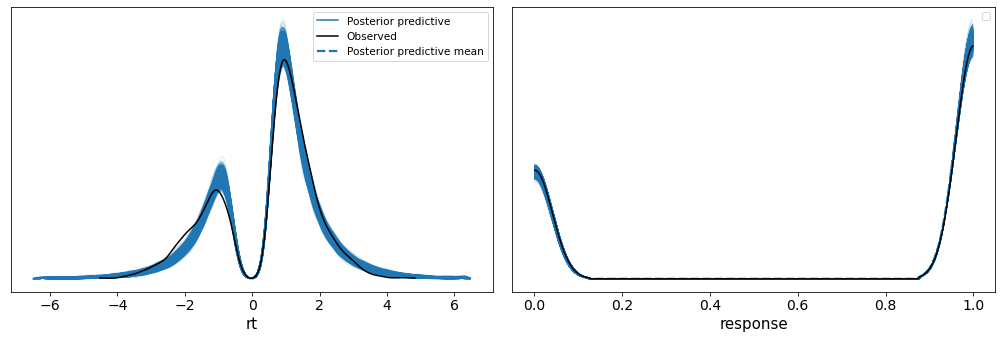

In [22]:
az.plot_ppc(InfData_1)

## Below are codes for debugging, I keep them just in case of re-use

In [10]:
def parallel(func, *args, show=True, thread=False, **kwargs):
    """
    Parallel processing
    from Wan-Ke Pan, Shanghai Normal Uni, Shanghai, China.
    :param func: 函数，必选参数
    :param args: list/tuple/iterable,1个或多个函数的动态参数，必选参数
    :param show:bool, default is True, whether show the progress.
    :param thread:bool,默认False,是否为多线程
    :param kwargs:1个或多个函数的静态参数，key-word形式
    :return:list,与函数动态参数等长
    """
    import time
    from functools import partial
    from pathos.pools import ProcessPool, ThreadPool
    from tqdm import tqdm
    # 冻结静态参数
    p_func = partial(func, **kwargs)
    # 打开进程/线程池
    pool = ThreadPool() if thread else ProcessPool()
    try:
        if show:
            start = time.time()
            # imap方法
            with tqdm(total=len(args[0]), desc="计算进度") as t:  # 进度条设置 not really 
                r = []
                for i in pool.imap(p_func, *args):
                    r.append(i)
                    t.set_postfix({'并行函数': func.__name__, "计算花销": "%ds" % (time.time() - start)})
                    t.update()
        else:
          # map方法
          r = pool.map(p_func, *args)
        return r
    except Exception as e:
        print(e)
    finally:
        # 关闭池
        pool.close()  # close the pool to any new jobs
        pool.join()  # cleanup the closed worker processes
        pool.clear()  # Remove server with matching state

In [11]:
def mult_chain(df, chains=4, samples=1500, burn=500, **argm):
    """
    mutliple chain in parallel, default samples=5000 burn=2000
    :param df: data
    :param chains: number of chains
    :return:a list of HDDM objects
    """
    import hddm
    # from third_module import parallel
    data_sets = [df] * chains
    def run_model(df, samples=samples, burn=burn, **argm):
        import hddm
        m = hddm.HDDM(df, depends_on={'v': 'stim'}, **argm)
#         samples = samples
#         burn = burn
        m.find_starting_values()
        m.sample(samples, burn, dbname='multi_chain', db='pickle')
        return m
    
    ms = parallel(run_model, data_sets, **argm)
    # results = hddm.analyze.gelman_rubin(ms)
    return ms

In [12]:
# may not necessary
def post_pred_par(ms, samples = 1500, **kwargs):
    import hddm
    
    def tmp_ppc(m, **argm):
        tmp_ppc = post_pred_gen(m, samples = samples)
        
        return tmp_ppc
    
    ppc_list = parallel(tmp_ppc, ms, samples = samples)
    
    return ppc_list

In [22]:
ms_par_3 = mult_chain(df, show=False, chains=chains, samples=samples, burn=burn)

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 9 of 1500 complete in 1.0 sec[                  0%                  ] 9 of 1500 complete in 1.0 sec[                  0%                  ] 9 of 1500 complete in 1.0 sec[                  0%                  ] 10 of 1500 complete in 1.2 sec[                  0%                  ] 13 of 1500 complete in 1.5 sec[                  0%                  ] 13 of 1500 complete in 1.6 sec[                  0%                  ] 13 of 1500 complete in 1.6 sec[                  1%                  ] 15 of 1500 complete in 1.8 sec[                  1%                  ] 17 of 1500 complete in 2.1 sec[                  1%                  ] 18 of 1500 complete in 2.1 sec[           

In [15]:
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/hddm/temp/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(1500, burn=500, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [16]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

ms_par_2 = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
195.490s elapsed

running model (depends on stim) 0
 [-----------------96%----------------  ] 1441 of 1500 complete in 191.3 sec
running model (depends on stim) 1
 [-----------------97%----------------- ] 1463 of 1500 complete in 191.4 sec
running model (depends on stim) 2
 [-----------------97%----------------  ] 1460 of 1500 complete in 190.6 sec
running model (depends on stim) 3
 [-----------------96%----------------  ] 1448 of 1500 complete in 191.0 sec

Running 4 chains used: 210.497044 seconds.


In [26]:
data_grouped = df.groupby(['subj_idx', 'stim'])
df_loglik2 = []

for ii in range(len(ms_par_4)):
    tmp_posterior = ms_par_4[ii].get_traces()
    tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
    # tmp_posterior.head()

    for group_name, df_grouped in data_grouped:
        tmp_df =data_grouped.get_group(group_name)
        tmp_df = np.array(tmp_df['rt'])

        a_colname = "a_subj." + str(group_name[0])
        t_colname = "t_subj." + str(group_name[0])
        v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

        for index, row in tmp_posterior.iterrows():
            tmp_a = row[a_colname]
            tmp_t = row[t_colname]
            tmp_v = row[v_colname]

            # Here we start using the pdf func of wfpt to calculate the likelihood
            tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                   v = np.array(tmp_v),
                                   a = np.array(tmp_a), 
                                   t = np.array(tmp_t),
                                   p_outlier = 0.05,
                                   sv = 0,
                                   z = 0.5,
                                   sz = 0,
                                   st = 0)

            if np.sum(tmp_lik == 0.0) > 0:
                print('Likelihood is zero, converted to 1/1e3 !\n')
                tmp_lik[tmp_lik == 0.0] = 1/1e300
                
            elif np.sum(np.isnan(tmp_lik))  > 0:
                print('NAN in the likelihood, check the data !')
                break

            obs = np.log(tmp_lik)

            if np.sum(np.isinf(obs)) > 0:
                print('Correction does not work!!!\n')

#                 if np.sum(np.isinf(obs)) > 0:
#                     print('Negative Infinite value occure, check the data!!!\n')
#                     np.nan_to_num(obs, copy=False, 
#                                   nan=0.0, posinf=0.0, neginf=np.log(1/1e300))
#                     if np.sum(np.isinf(obs)) > 0:
#                         print('Correction does not work!!!\n')
            tmp_df_pll = pd.DataFrame({'obs': obs,
                                       'draw': index,
                                       'subj_idx': group_name[0],
                                       'stim': group_name[1],
                                       'chain': ii})
            tmp_df_pll['trial'] = tmp_df_pll.groupby(['chain', 'draw', 'subj_idx', 'stim']).cumcount()
            df_loglik2.append(tmp_df_pll)


Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1

In [27]:
df_loglik_tmp = pd.concat(df_loglik2)
df_loglik_tmp

obs  draw  subj_idx stim  chain  trial
0  -1.308364     0         0   LL      0      0
1  -2.043207     0         0   LL      0      1
2  -1.778424     0         0   LL      0      2
3  -1.778424     0         0   LL      0      3
4  -2.351803     0         0   LL      0      4
..       ...   ...       ...  ...    ...    ...
66 -4.487563   999        13   WW      3     66
67 -1.241597   999        13   WW      3     67
68 -1.466772   999        13   WW      3     68
69 -1.637677   999        13   WW      3     69
70 -1.027023   999        13   WW      3     70

[15952000 rows x 6 columns]

In [32]:
df_loglik_tmp[df_loglik_tmp['chain'] == 0].head()

obs  draw  subj_idx stim  chain  trial
0 -1.308364     0         0   LL      0      0
1 -2.043207     0         0   LL      0      1
2 -1.778424     0         0   LL      0      2
3 -1.778424     0         0   LL      0      3
4 -2.351803     0         0   LL      0      4

In [35]:
df_loglik_tmp[df_loglik_tmp['chain'] == 3].head()

obs  draw  subj_idx stim  chain  trial
0 -1.286949     0         0   LL      3      0
1 -2.077088     0         0   LL      3      1
2 -1.792497     0         0   LL      3      2
3 -1.792497     0         0   LL      3      3
4 -2.318626     0         0   LL      3      4

In [33]:
df_loglik[df_loglik_tmp['chain'] == 0].head()

obs  draw  subj_idx stim  trial  chain
0 -1.308364     0         0   LL      0      0
1 -2.043207     0         0   LL      1      0
2 -1.778424     0         0   LL      2      0
3 -1.778424     0         0   LL      3      0
4 -2.351803     0         0   LL      4      0

In [18]:
tmp_posterior = ms_par_1[0].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  2.106838  0.368337  2.147248  2.095126  1.580618  1.923144  1.478098   
1  1.862598  0.480305  2.101338  2.144495  1.696143  2.028150  1.489714   
2  2.004161  0.283071  2.091868  2.038183  1.595268  2.137567  1.466046   
3  2.020000  0.233347  2.237619  2.134765  1.671588  2.153977  1.508709   
4  2.004208  0.406208  2.120790  2.138372  1.633966  2.204362  1.539682   
5  1.984199  0.389569  2.130820  2.164230  1.617153  2.104006  1.527740   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.801904  1.622773  1.799359  ...  0.335501  0.355001  0.420961  0.599526   
1  1.750893  1.579369  1.795901  ...  0.351304  0.363479  0.425603  0.589047   
2  1.699442  1.576851  1.788251  ...  0.349564  0.363370  0.430831  0.588596   
3  1.684600  1.544917  1.902163  ...  0.352659  0.364868  0.428875  0.579420   
4  1.759699  1.583627  1.879641  ...  0.350656  0.340300  0.427562  0.588193   
5  1.680320  1.528118  1.724870  ...  0.328889  0.359384  0.436456  0.617492   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.516394  0.371831   0.645623   0.577120   0.407567   0.542901  
1  0.546528  0.362403   0.655803   0.589701   0.391543   0.544448  
2  0.548081  0.370922   0.659696   0.572220   0.376946   0.548142  
3  0.558010  0.384297   0.654284   0.659288   0.383599   0.560695  
4  0.555635  0.362526   0.655080   0.620671   0.424434   0.589547  
5  0.523955  0.359199   0.662191   0.590485   0.411908   0.575094  

[6 rows x 78 columns]

In [17]:
tmp_posterior = ms_par_1[1].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  2.106838  0.368337  2.147248  2.095126  1.580618  1.923144  1.478098   
1  1.862598  0.480305  2.101338  2.144495  1.696143  2.028150  1.489714   
2  2.004161  0.283071  2.091868  2.038183  1.595268  2.137567  1.466046   
3  2.020000  0.233347  2.237619  2.134765  1.671588  2.153977  1.508709   
4  2.004208  0.406208  2.120790  2.138372  1.633966  2.204362  1.539682   
5  1.984199  0.389569  2.130820  2.164230  1.617153  2.104006  1.527740   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.801904  1.622773  1.799359  ...  0.335501  0.355001  0.420961  0.599526   
1  1.750893  1.579369  1.795901  ...  0.351304  0.363479  0.425603  0.589047   
2  1.699442  1.576851  1.788251  ...  0.349564  0.363370  0.430831  0.588596   
3  1.684600  1.544917  1.902163  ...  0.352659  0.364868  0.428875  0.579420   
4  1.759699  1.583627  1.879641  ...  0.350656  0.340300  0.427562  0.588193   
5  1.680320  1.528118  1.724870  ...  0.328889  0.359384  0.436456  0.617492   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.516394  0.371831   0.645623   0.577120   0.407567   0.542901  
1  0.546528  0.362403   0.655803   0.589701   0.391543   0.544448  
2  0.548081  0.370922   0.659696   0.572220   0.376946   0.548142  
3  0.558010  0.384297   0.654284   0.659288   0.383599   0.560695  
4  0.555635  0.362526   0.655080   0.620671   0.424434   0.589547  
5  0.523955  0.359199   0.662191   0.590485   0.411908   0.575094  

[6 rows x 78 columns]

In [19]:
tmp_posterior = ms_par_2[0].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  1.924119  0.414367  2.160005  2.217315  1.503121  2.125555  1.529433   
1  2.110207  0.329548  2.350129  2.205754  1.536573  2.119526  1.526557   
2  1.968555  0.333480  2.206351  2.231381  1.673238  2.165669  1.557523   
3  2.038374  0.274651  2.131821  2.229229  1.634931  2.158273  1.475563   
4  1.955564  0.386626  2.150115  2.159387  1.536419  2.140765  1.484542   
5  1.771328  0.284875  2.161367  2.125822  1.520614  2.116804  1.500853   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.768520  1.626737  1.787540  ...  0.336271  0.349910  0.407843  0.621720   
1  1.768264  1.643596  1.696270  ...  0.346220  0.359094  0.413393  0.592272   
2  1.802880  1.658920  1.732113  ...  0.343917  0.347581  0.408628  0.632182   
3  1.766115  1.649201  1.726819  ...  0.349590  0.354020  0.411680  0.581670   
4  1.751763  1.649396  1.751853  ...  0.349425  0.350225  0.410819  0.598762   
5  1.841387  1.627289  1.757863  ...  0.350335  0.324127  0.422279  0.601842   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.560036  0.370694   0.679845   0.630257   0.399498   0.576743  
1  0.536218  0.402798   0.683117   0.613309   0.406670   0.565320  
2  0.529497  0.377047   0.667484   0.624466   0.406655   0.513982  
3  0.555182  0.377094   0.683325   0.600014   0.391852   0.488757  
4  0.539549  0.387871   0.689393   0.587002   0.389394   0.478001  
5  0.568300  0.363069   0.663642   0.606263   0.394476   0.514873  

[6 rows x 78 columns]

In [20]:
tmp_posterior = ms_par_2[1].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  2.072315  0.352861  2.105855  2.106389  1.587070  2.244043  1.414825   
1  2.022739  0.315983  2.275415  2.075249  1.645526  2.174029  1.439127   
2  1.962582  0.330352  2.190216  2.149502  1.530240  2.137834  1.491252   
3  2.083020  0.341072  2.153496  2.187693  1.628523  2.204502  1.517629   
4  1.980893  0.267363  2.177576  2.197855  1.591387  2.323625  1.537922   
5  2.052356  0.260263  2.185643  2.208121  1.526045  2.260950  1.445934   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.788883  1.716904  1.867284  ...  0.354716  0.344132  0.417180  0.593270   
1  1.867434  1.738469  1.782123  ...  0.351998  0.338358  0.399951  0.595907   
2  1.875378  1.621952  1.822474  ...  0.346757  0.328264  0.409849  0.600574   
3  1.838959  1.579170  1.818918  ...  0.340084  0.340082  0.420693  0.579752   
4  1.777879  1.691428  1.833349  ...  0.350422  0.347999  0.428789  0.603832   
5  1.782292  1.661238  1.825734  ...  0.342081  0.354863  0.416752  0.611025   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.535697  0.345101   0.627732   0.601363   0.393783   0.521096  
1  0.542146  0.356302   0.629141   0.587493   0.407171   0.554715  
2  0.520796  0.363575   0.622377   0.593085   0.414197   0.503092  
3  0.544258  0.366997   0.664668   0.615667   0.394609   0.525140  
4  0.559152  0.390212   0.658464   0.628236   0.406084   0.496296  
5  0.532623  0.379640   0.674319   0.583151   0.391103   0.539319  

[6 rows x 78 columns]

In [31]:
tmp_posterior = ms_par_4[0].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  2.082197  0.364945  2.168495  2.122758  1.540810  2.144856  1.514397   
1  2.010216  0.320177  2.300230  2.063128  1.509392  2.212517  1.474066   
2  2.067346  0.419544  2.254321  2.215290  1.492070  2.091696  1.413712   
3  2.050300  0.382536  2.330228  2.273605  1.537246  2.234132  1.518632   
4  2.164212  0.455943  2.251439  2.231422  1.588171  2.211380  1.464901   
5  2.192215  0.413087  2.239603  2.177101  1.578971  2.272860  1.401395   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.803159  1.599371  1.820130  ...  0.337770  0.343114  0.427803  0.607605   
1  1.849666  1.525865  1.822261  ...  0.351991  0.358042  0.421173  0.590098   
2  1.755132  1.538473  1.750074  ...  0.348960  0.356230  0.442379  0.605240   
3  1.864523  1.505845  1.833420  ...  0.353923  0.346325  0.439753  0.600063   
4  1.809111  1.580421  1.824419  ...  0.349216  0.339780  0.430794  0.581782   
5  1.916873  1.516349  1.786696  ...  0.356820  0.339798  0.429032  0.602328   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.595586  0.361771   0.657255   0.626901   0.397944   0.461127  
1  0.520816  0.375455   0.625618   0.561209   0.394919   0.479304  
2  0.527267  0.363966   0.665081   0.562031   0.395659   0.494188  
3  0.567238  0.362710   0.646112   0.592724   0.396794   0.545665  
4  0.515072  0.363095   0.645130   0.577082   0.412037   0.547547  
5  0.578944  0.376252   0.669424   0.572302   0.403499   0.578201  

[6 rows x 78 columns]

In [30]:
tmp_posterior = ms_par_4[1].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  2.127807  0.417842  2.107397  2.184241  1.595761  2.154497  1.390555   
1  1.950002  0.237899  2.184069  2.169337  1.584635  2.188300  1.546352   
2  1.887378  0.410043  2.180224  2.058991  1.567174  2.161737  1.372160   
3  2.082343  0.286377  2.349545  2.083389  1.586091  2.133484  1.392571   
4  1.854756  0.284605  2.159310  2.082217  1.571458  2.051534  1.454029   
5  1.992675  0.329634  2.153061  2.048229  1.615574  2.173551  1.412789   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.872432  1.520657  1.848751  ...  0.357251  0.350538  0.424604  0.592098   
1  1.809582  1.554892  1.803205  ...  0.348645  0.332588  0.436426  0.592659   
2  1.811418  1.526734  1.688673  ...  0.354924  0.333405  0.437728  0.603945   
3  1.864112  1.551653  1.710180  ...  0.354345  0.335328  0.434758  0.615950   
4  1.875275  1.562401  1.791356  ...  0.359928  0.342840  0.438463  0.608524   
5  1.886683  1.626359  1.755868  ...  0.361843  0.343284  0.430645  0.597637   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.544742  0.387339   0.662566   0.632097   0.388806   0.554742  
1  0.551687  0.348169   0.662691   0.597593   0.398577   0.535795  
2  0.577701  0.373534   0.655713   0.653440   0.405447   0.564669  
3  0.585292  0.366155   0.637456   0.638944   0.395060   0.541026  
4  0.528492  0.375009   0.622284   0.603043   0.401734   0.506345  
5  0.553786  0.398599   0.623192   0.613519   0.407520   0.538623  

[6 rows x 78 columns]

In [32]:
tmp_posterior = ms_par_4[2].get_traces().head(6)
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0  1.982224  0.342829  2.231223  2.180663  1.578173  2.144818  1.499440   
1  1.945989  0.261398  2.166481  2.144068  1.493342  2.148752  1.492827   
2  1.963571  0.259004  2.130465  2.115253  1.506898  2.164943  1.546121   
3  1.937008  0.269799  2.152954  2.163432  1.541590  2.102319  1.547957   
4  1.969853  0.237256  2.335832  2.111652  1.563196  2.146033  1.514981   
5  1.949488  0.414322  2.306552  2.078935  1.569440  2.153193  1.403580   

   a_subj.5  a_subj.6  a_subj.7  ...  t_subj.4  t_subj.5  t_subj.6  t_subj.7  \
0  1.713322  1.560237  1.719027  ...  0.348148  0.365613  0.442977  0.613846   
1  1.770678  1.588878  1.807617  ...  0.344462  0.363941  0.423123  0.614372   
2  1.838610  1.593474  1.718991  ...  0.342034  0.356409  0.427763  0.611743   
3  1.784879  1.553014  1.769131  ...  0.328552  0.347030  0.435388  0.605481   
4  1.819819  1.560572  1.784409  ...  0.349488  0.342914  0.424397  0.602526   
5  1.805870  1.505062  1.754817  ...  0.356851  0.346257  0.429792  0.605393   

   t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  
0  0.526622  0.368251   0.639227   0.634934   0.382942   0.567573  
1  0.539586  0.370965   0.641287   0.631628   0.392996   0.553416  
2  0.539766  0.385728   0.629833   0.629101   0.390242   0.545356  
3  0.523150  0.381742   0.639370   0.615774   0.372363   0.528187  
4  0.548216  0.382176   0.654459   0.628026   0.398146   0.529089  
5  0.530861  0.383095   0.641142   0.594363   0.408686   0.550211  

[6 rows x 78 columns]

In [42]:
ms1[1].dic

10786.281788958604

In [43]:
ms1[0].dic

10786.281788958602

In [44]:
ms1[2].dic

10786.281788958602

In [45]:
ms1[3].dic

10786.281788958606

In [19]:
# run 4 chain's plld in parallel
df_loglik_par = parallel(calc_plld, ms1, observed=df)

计算进度: 100%|██████████| 4/4 [02:16<00:00, 34.14s/it, 并行函数=calc_plld, 计算花销=136s] 


In [20]:
df_loglik_par # there is some problem here, each chain is exactly the same??

[         obs  draw  subj_idx stim  trial
 0  -1.109589     0         0   LL      0
 1  -1.949954     0         0   LL      1
 2  -1.649014     0         0   LL      2
 3  -1.649014     0         0   LL      3
 4  -2.540479     0         0   LL      4
 ..       ...   ...       ...  ...    ...
 66 -4.349867   999        13   WW     66
 67 -1.377207   999        13   WW     67
 68 -1.697522   999        13   WW     68
 69 -1.509065   999        13   WW     69
 70 -1.314315   999        13   WW     70
 
 [3988000 rows x 5 columns],
          obs  draw  subj_idx stim  trial
 0  -1.109589     0         0   LL      0
 1  -1.949954     0         0   LL      1
 2  -1.649014     0         0   LL      2
 3  -1.649014     0         0   LL      3
 4  -2.540479     0         0   LL      4
 ..       ...   ...       ...  ...    ...
 66 -4.349867   999        13   WW     66
 67 -1.377207   999        13   WW     67
 68 -1.697522   999        13   WW     68
 69 -1.509065   999        13   WW     69
 70

In [ ]:

# 4.2 posterior
df_traces = []
for jj in range(len(ms)):
    m = ms[jj]
    trace_tmp = m.get_traces()
    trace_tmp['chain'] = jj
    trace_tmp['draw'] = np.arange(len(trace_tmp), dtype=int)
    print('chain', jj, trace_tmp.shape)
    df_traces.append(trace_tmp)
df_traces = pd.concat(df_traces)
df_traces = df_traces.set_index(["chain", "draw"])
xdata_posterior = xr.Dataset.from_dataframe(df_traces)

# 4.3 posterior predictive
df_ppc = []
for kk in range(len(ppc_list)):
    ppc_tmp = ppc_list[kk]
#     df_post_pred = hddm.utils.post_pred_gen(m, samples = 1500)
    ppc_tmp.reset_index(inplace=True)
    ppc_tmp['chain'] = kk
    ppc_tmp.rename(columns={'sample':'draw',
                        'level_2':'trial'}, inplace=True)
    print('\nchain', kk, ppc_tmp.shape)

    ppc_tmp[['stim', 'subj_idx']] = ppc_tmp['node'].str.split(pat='\.', expand=True)

    # extract the stim string between "(" and ")"

    ppc_tmp['stim'] = ppc_tmp['stim'].str.extract('.*\((.*)\).*')
    ppc_tmp.drop('node', axis=1, inplace=True)
    df_ppc.append(ppc_tmp)

df_ppc = pd.concat(df_ppc)
xdata_post_pred = xr.Dataset.from_dataframe(df_ppc)

# point-wise log lik
df_loglik = pd.concat(df_loglik)
df_loglik = df_loglik.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
xdata_loglik = xr.Dataset.from_dataframe(df_loglik)

# convert to InferenceData
print("start to convert to Inference data.\n")
InfData = az.InferenceData(posterior=xdata_posterior, 
                           observed_data=xdata_observed,
                           posterior_predictive=xdata_post_pred,
                           log_likelihood = xdata_loglik)


In [16]:
# get the InferenceData from truncated data
ms2, df_traces_2, df_pp_2, InfData_2 = model_to_arviz(data_trunc) 

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 1500 complete in 0.5 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 11 of 1500 complete in 1.1 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  1%                  ] 16 of 1500 complete in 1.7 sec[                  1%                  ] 16 of 1500 complete in 1.7 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 21 of 1500 complete in 2.3 sec[                  1%                  ] 21 of 1500 complete in 2.3 sec[        

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 ----             11%                  ] 5 of 42 complete in 25.4 secc[---               9%                  ] 4 of 42 complete in 12.3 sec[---               9%                  ] 4 of 42 complete in 12.3 sec[---               9%                  ] 4 of 42 complete in 12.4 sec[----             11%                  ] 5 of 42 complete in 25.2 sec [----             11%                  ] 5 of 42 complete in 25.4 sec[----             11%                  ] 5 of 42 complete in 25.5 sec[-----            14%                  ] 6 of 42 complete in 36.4 sec[-----            14%                  ] 6 of 42 complete in 36.5 sec[-----            14%                  ] 6 of 42 complete in 36.5 sec[-----            14%                  ] 6 of 42 complete in 36.8 sec[------           16%                  ] 7 of 42 complete in 49.6 sec[------           16%                  ] 7 of 42 complete in 49.6 sec[------           16%                  ] 7 of 42 complete in 50.0 sec[------           16%           

计算进度:  25%|██▌       | 1/4 [08:53<26:41, 533.79s/it, 并行函数=tmp_ppc, 计算花销=533s]

 [------------------107%------------------] 45 of 42 complete in 532.6 sec[------------------107%------------------] 45 of 42 complete in 533.2 sec

计算进度: 100%|██████████| 4/4 [08:54<00:00, 133.69s/it, 并行函数=tmp_ppc, 计算花销=534s]


Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure,

In [17]:
az.waic(InfData_2)

Computed from 4000 by 2226 log-likelihood matrix

          Estimate       SE
elpd_waic -380101.76  144678.05
p_waic    376949.44        -

There has been a warning during the calculation. Please check the results.

In [18]:
# get the InferenceData from truncated data
ms1, df_traces_1, df_pp_1, InfData_1 = model_to_arviz(data) 

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 5 of 1500 complete in 0.5 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 10 of 1500 complete in 1.1 sec[                  0%                  ] 10 of 1500 complete in 1.1 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 15 of 1500 complete in 1.7 sec[                  1%                  ] 15 of 1500 complete in 1.7 sec[                  1%                  ] 21 of 1500 complete in 2.4 sec  [                  1%                  ] 19 of 1500 complete in 2.2 sec[      

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 13.1 sec[---               9%                  ] 4 of 42 complete in 13.1 sec[---               9%                  ] 4 of 42 complete in 13.2 sec[---               9%                  ] 4 of 42 complete in 13.2 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[----             11%                  ] 5 of 42 complete in 26.4 sec[-----            14%                  ] 6 of 42 complete in 38.4 sec[-----            14%                  ] 6 of 42 complete in 38.5 sec[-----            14%                  ] 6 of 42 complete in 38.7 sec[-----            14%                  ] 6 of 42 complete in 38.7 sec[------           16%                  ] 7 of 42 complete in 51.5 sec[------           16%                  ] 7 of 42 complete in 51.7 sec[------           16%            

计算进度:  50%|█████     | 2/4 [09:02<12:39, 379.62s/it, 并行函数=tmp_ppc, 计算花销=542s]

 [------------------107%------------------] 45 of 42 complete in 542.8 sec

计算进度: 100%|██████████| 4/4 [09:04<00:00, 136.16s/it, 并行函数=tmp_ppc, 计算花销=544s]


Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure,

In [20]:
az.waic(InfData_1)

Computed from 4000 by 6594 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

There has been a warning during the calculation. Please check the results.

### debug notes:
it turned out that the `nan` results from `az.waic` are caused by `np.var(waic_i.values)` @arviz/stats/stats.py#L1467, which is in turn caused by the fact that `waic_i.values` contains `nan`. So, the next step of debugging, is to find out why there are `nan` value in `waic_i.values`.

`waic_i.values` is calculated as below:

```
lppd_i = _wrap_xarray_ufunc(
        _logsumexp,
        log_likelihood,
        func_kwargs={"b_inv": n_samples},
        ufunc_kwargs=ufunc_kwargs,
        dask_kwargs=dask_kwargs,
        **kwargs,
    )

vars_lpd = log_likelihood.var(dim="__sample__")
    
waic_i = scale_value * (lppd_i - vars_lpd)
```

After using for loop to check every element of `log_likelihood` and `lppd_i`, I found that they do not have `nan`. It turned out that the `nan` is from `vars_lpd`, which is caused by `-inf` in the `loglikelihood`. After double-check the `wfpt` likelihood function, I found that certain RT data return `0.` likelihood, and therefor `-inf` log-likelihood. This can be reproduced.

To solved the problem I add an `if` in when calculating the log-likelihood: if the likelihood is 0, I turn its log into $np.log(1/1e300)$, which is the approaching the maxium  of `np.log`.

In [15]:
df = data_trunc

In [16]:
ms = mult_chain(data_trunc, chains=4)

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 6 of 1500 complete in 0.6 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  0%                  ] 11 of 1500 complete in 1.2 sec[                  1%                  ] 16 of 1500 complete in 1.7 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 16 of 1500 complete in 1.8 sec[                  1%                  ] 21 of 1500 complete in 2.3 sec[                  1%                  ] 21 of 1500 complete in 2.4 sec[        

计算进度: 100%|██████████| 4/4 [03:12<00:00, 48.12s/it, 并行函数=temp, 计算花销=192s] 


In [22]:
ms1[0].dic
print("DIC of the first model is %f" % ms1[0].dic)

DIC of the first model is 10787.588918


In [23]:
ii = 0
ii

0

In [24]:
tmp_posterior = ms1[ii].get_traces()
tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
tmp_posterior

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0    1.959272  0.296847  2.208989  2.234965  1.560232  2.173869  1.532632   
1    2.017510  0.394722  2.167097  2.295497  1.589493  2.185478  1.544310   
2    2.004467  0.260299  2.252148  2.267664  1.626500  2.119630  1.538223   
3    2.049744  0.410160  2.197918  2.081579  1.610317  2.321974  1.508284   
4    1.953580  0.258601  2.239054  2.142025  1.600767  2.094651  1.538549   
..        ...       ...       ...       ...       ...       ...       ...   
995  2.065529  0.281558  2.290773  2.160299  1.516628  2.149222  1.531081   
996  1.907329  0.289926  2.271442  2.159016  1.606459  2.126153  1.499940   
997  1.954630  0.263592  2.219979  2.140420  1.563330  2.139853  1.476986   
998  1.951173  0.293675  2.182921  2.141751  1.533834  2.211841  1.509669   
999  2.123633  0.326357  2.240987  2.133201  1.571092  2.302683  1.447107   

     a_subj.5  a_subj.6  a_subj.7  ...  t_subj.5  t_subj.6  t_subj.7  \
0    1.871321  1.605772  1.796052  ...  0.334049  0.403684  0.600026   
1    1.810503  1.532246  1.805201  ...  0.345488  0.448187  0.594011   
2    1.759913  1.524179  1.806132  ...  0.351175  0.440874  0.593536   
3    1.769198  1.551373  1.825442  ...  0.359318  0.447263  0.591457   
4    1.787469  1.681781  1.806786  ...  0.351343  0.431785  0.608660   
..        ...       ...       ...  ...       ...       ...       ...   
995  1.856147  1.583909  1.737074  ...  0.364409  0.422020  0.603557   
996  1.893080  1.590801  1.809559  ...  0.333343  0.430400  0.611839   
997  1.876434  1.615639  1.716498  ...  0.333071  0.411367  0.615130   
998  1.843402  1.586114  1.769776  ...  0.355330  0.435235  0.610302   
999  1.822827  1.571239  1.755113  ...  0.358388  0.430337  0.616196   

     t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  samples  
0    0.541621  0.343475   0.666635   0.618056   0.407761   0.528117        0  
1    0.500359  0.352602   0.649385   0.628109   0.408204   0.493314        1  
2    0.539198  0.371259   0.651008   0.618993   0.391389   0.495684        2  
3    0.517825  0.373181   0.665160   0.622576   0.383500   0.508031        3  
4    0.515146  0.367009   0.654410   0.578833   0.399760   0.526031        4  
..        ...       ...        ...        ...        ...        ...      ...  
995  0.518545  0.365310   0.647420   0.579552   0.389204   0.496948      995  
996  0.582740  0.352415   0.651211   0.593826   0.398098   0.535899      996  
997  0.529169  0.341568   0.666359   0.595895   0.394816   0.560921      997  
998  0.543696  0.358779   0.666086   0.633789   0.402168   0.541003      998  
999  0.493605  0.351257   0.662388   0.590783   0.413958   0.548608      999  

[1000 rows x 79 columns]

In [43]:
tmp_df = np.array(data['rt'][(data['subj_idx'] == 0) & (data['stim'] == 'LL')])
tmp_df

array([ 1.21 ,  2.   ,  1.72 ,  1.72 , -2.44 , -0.987, -1.17 , -2.84 ,
        2.35 ,  1.46 ,  2.76 , -2.15 , -1.38 ,  3.17 , -3.83 , -1.49 ,
        0.886,  0.968,  0.841, -2.87 , -3.66 , -0.602, -1.25 , -1.98 ,
        2.2  , -1.93 ,  1.5  , -1.65 ,  1.56 ,  1.15 ,  0.814,  1.08 ,
       -1.59 ,  2.02 ,  1.36 ,  1.15 ,  2.34 ,  1.23 ,  2.38 ,  2.26 ,
        1.98 , -3.52 ,  1.74 , -1.98 ,  1.5  ,  2.52 ,  3.82 ,  3.51 ,
       -1.17 , -3.22 , -3.02 , -1.71 , -1.02 , -1.17 , -1.95 ,  1.84 ,
       -1.87 , -2.31 ,  1.66 , -0.935,  1.71 , -1.49 , -2.03 ,  1.08 ,
       -1.45 , -0.848,  2.01 , -1.81 ,  1.2  , -1.55 , -1.92 , -1.23 ,
       -1.16 ])

In [40]:
a_colname = "a_subj." + str(0)
t_colname = "t_subj." + str(0)
v_colname = "v_subj(LL)." + str(0)
print(a_colname)
print(t_colname)
print(v_colname)

a_subj.0
t_subj.0
v_subj(LL).0


In [36]:
a = np.array([1.0, 2.0, 3.5,4,0.0, 0, 3])
a.any(0)

True

In [38]:
np.sum(a == 0.0)

2

In [34]:
a[a == 0.0] = 0.1
a

array([1. , 2. , 3.5, 4. , 0.1, 0.1, 3. ])

In [44]:
for index, row in tmp_posterior.iterrows():
    tmp_a = row[a_colname]
    tmp_t = row[t_colname]
    tmp_v = row[v_colname]
#     print("a:", tmp_a)
#     print("t:", tmp_t)
#     print("v:", tmp_v)
    
    tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)
#     print(tmp_lik)
    if np.sum(tmp_lik == 0.0) > 0:
        print('Likelihood is zero, converted to 1/1e3 !\n')
        tmp_lik[tmp_lik == 0.0] = 1/1e300
    elif np.sum(np.isnan(tmp_lik))  > 0:
        print('NAN in the likelihood, check the data !')
        break
        
#     tmp_lik_log = np.log(tmp_lik)
#     if np.sum(np.isinf(tmp_lik_log)) > 0:
# #     if np.isinf(tmp_lik_log):
#         print('Negative Infinite value occure, check the data!!!\n')
#         np.nan_to_num(tmp_lik_log, copy=False, 
#                                 nan=0.0, posinf=0.0, neginf=np.log(1/1e300))
# #         tmp_lik_log = np.log(tmp_lik)
#         if np.sum(np.isinf(tmp_lik_log)) > 0:
#             print('Correction does not work!!!\n')
        

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1/1e3 !

Likelihood is zero, converted to 1

In [42]:
print("a:", tmp_a)
print("t:", tmp_t)
print("v:", tmp_v)

a: 2.412409870763292
t: 0.4834175706377592
v: 0.19202350690923675


In [43]:
hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)

array([0.33701231, 0.17373279, 0.2213012 , 0.2213012 , 0.07467671,
       0.2371046 , 0.21802235, 0.05280578, 0.12830082, 0.27629717,
       0.08994247, 0.09600373, 0.1857986 , 0.06305167, 0.02239647,
       0.16952187, 0.36759605, 0.37734157, 0.35009861, 0.05145096,
       0.02595043, 0.01919669, 0.20591891, 0.11122908, 0.1461039 ,
       0.11614781, 0.26713957, 0.1478971 , 0.25386582, 0.35103976,
       0.33372593, 0.36535465, 0.15570259, 0.17075056, 0.30013357,
       0.35103976, 0.12941713, 0.33215511, 0.12500928, 0.13870425,
       0.17676678, 0.0292969 , 0.21751845, 0.11122908, 0.26713957,
       0.1107305 , 0.03590249, 0.04696417, 0.21802235, 0.03799278,
       0.0451808 , 0.14045696, 0.23544945])

In [61]:
data_grouped = df.groupby(['subj_idx', 'stim'])
df_loglik = []
for ii in range(len(ms)):
    tmp_posterior = ms[ii].get_traces()
    tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
    # tmp_posterior.head()

    for group_name, df_grouped in data_grouped:
        tmp_df =data_grouped.get_group(group_name)
        tmp_df = np.array(tmp_df['rt'])

        a_colname = "a_subj." + str(group_name[0])
        t_colname = "t_subj." + str(group_name[0])
        v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

        for index, row in tmp_posterior.iterrows():
            tmp_a = row[a_colname]
            tmp_t = row[t_colname]
            tmp_v = row[v_colname]

            # Here we start using the pdf func of wfpt to calculate the likelihood
            tmp_lik = hddm.wfpt.pdf_array(x = tmp_df,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a), 
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)
            obs = np.log(tmp_lik)
            
            if np.sum(np.isinf(obs)) > 0:
                print('Negative Infinite value occure, check the data!!!\n')
                np.nan_to_num(obs, copy=False, 
                              nan=0.0, posinf=0.0, neginf=np.log(1/1e300))
                if np.sum(np.isinf(obs)) > 0:
                    print('Correction does not work!!!\n')
            
#             if np.sum(np.isneginf(tmp_lik)) > 0:
#                 print('Negative Infinite value occure, check the data!!!\n')
# #                 print("The a value is %f" % tmp_a)
# #                 print("The v value is %f" % tmp_v)
# #                 print("The t value is %f" % tmp_t)
#                 print("The chain is %f" % ii)
#                 print("The subj_idx is: ", group_name[0])
#                 print("The condition is: ", group_name[1])

# #                 tmp_lik.replace(np.inf, 1/1e300, inplace=True)
#                 tmp_lik = np.nan_to_num(tmp_lik, copy=False, 
#                                         nan=0.0, posinf=0.0, neginf=1/1e300)
                
#             obs = np.log(tmp_lik)
            
#             if np.isnan(np.sum(obs)):
#                 print('NAN value occure, check the data!!!\n')
#                 print("The a value is %f" % tmp_a)
#                 print("The v value is %f" % tmp_v)
#                 print("The t value is %f" % tmp_t)
#                 print("The subj_idx is: ", group_name[0])
#                 print("The condition is: ", group_name[1])
#                 print("The chain is %f" % ii)
                
            tmp_df_pll = pd.DataFrame({'obs': obs,
                                       'draw': index,
                                       'subj_idx': group_name[0],
                                       'stim': group_name[1],
                                       'chain': ii})
            tmp_df_pll['trial'] = tmp_df_pll.groupby(['chain', 'draw', 'subj_idx', 'stim']).cumcount()
            df_loglik.append(tmp_df_pll)

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure, check the data!!!

Negative Infinite value occure,

In [62]:
df_loglik = pd.concat(df_loglik)
df_loglik = df_loglik.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])

In [60]:
data.shape

(3988, 8)

In [59]:
ppc_list[0]

rt  response
node        sample                       
wfpt(LL).0  0      0  -1.067820       0.0
                   1   2.593020       1.0
                   2   0.888420       1.0
                   3  -2.943420       0.0
                   4   0.897720       1.0
...                         ...       ...
wfpt(WW).13 999    66  3.052176       1.0
                   67  0.937176       1.0
                   68 -1.695376       0.0
                   69 -0.839176       0.0
                   70 -1.558276       0.0

[3988000 rows x 2 columns]

In [63]:
np.isinf(df_loglik).values.sum()

0

In [64]:
df_loglik[np.isinf(df_loglik).values]

Empty DataFrame
Columns: [obs]
Index: []

In [65]:
tmp_log_likelihood = xr.Dataset.from_dataframe(df_loglik)

In [66]:
np.sum(np.isinf(tmp_log_likelihood.to_array().values)) 

0

In [83]:
tmp_log_likelihood2 = tmp_log_likelihood.to_array()
tmp_log_likelihood2

<xarray.DataArray (variable: 1, chain: 4, draw: 1000, subj_idx: 14, stim: 3, trial: 53)>
array([[[[[[-1.3910905 , -2.11805675, -1.85430079, ..., -2.76735455,
            -1.53214337, -0.95849805],
           [-1.60431183, -2.66826775, -1.18392301, ..., -1.5621741 ,
            -1.60431183, -3.22865703],
           [-1.06731681, -1.22320291, -1.12106312, ..., -2.11772212,
            -2.99643118, -1.23754409]],

          [[-1.98776268, -2.27847569, -0.91149065, ..., -2.67845872,
            -1.28126474, -2.22496797],
           [-1.05954253, -0.63192122, -0.38735014, ..., -0.679614  ,
            -4.60983241, -1.8120736 ],
           [-2.60384804, -1.6824216 , -0.63737965, ..., -1.38109575,
            -0.70594558, -1.39277352]],

          [[-0.46848695, -1.00686794, -0.34034331, ..., -1.14841843,
            -3.29544315, -1.91755775],
           [-0.18483049, -0.93024045, -2.50510945, ..., -1.05940874,
            -1.54063813, -1.11155231],
           [-0.53081843, -1.59992753, -0.5291303 , ..., -0.67968107,
            -1.33254138, -1.64855448]],
...
          [[-1.66572546, -1.17480439, -1.94233975, ..., -1.10363652,
            -0.77755524, -3.45374505],
           [-3.39808169, -0.37186106, -0.9295871 , ..., -0.99911799,
            -2.5220742 , -1.74804192],
           [-1.82305393, -2.07869116, -1.55570639, ..., -2.46053355,
            -1.59110543, -2.21310816]],

          [[-1.16236576, -0.80324842, -1.2632681 , ..., -1.45276893,
            -1.16236576, -0.60819711],
           [-0.65926592, -1.7512597 , -0.70551068, ..., -0.64388436,
            -1.14021892, -1.46053456],
           [-1.37779652, -1.05494429, -0.4809938 , ..., -0.41761496,
            -1.49848495, -0.48635027]],

          [[-1.00967717, -1.37810831, -0.90701954, ..., -1.85208496,
            -1.47823484, -1.98450267],
           [-0.83839962, -1.60777232, -1.53860913, ..., -1.36591917,
            -0.83030226, -1.95670417],
           [-1.26465604, -1.73563095, -1.83316446, ..., -2.08910728,
            -1.98970116, -1.96023115]]]]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * variable  (variable) <U3 'obs'

In [84]:
tmp_log_likelihood2 = tmp_log_likelihood2.stack(__sample__=("chain", "draw"))
shape = tmp_log_likelihood2.shape
print("shape: ", shape)
n_samples = shape[-1]
n_data_points = np.product(shape[:-1])

ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}
lppd_i = _wrap_xarray_ufunc(
    _logsumexp,
    tmp_log_likelihood2,
    func_kwargs={"b_inv": n_samples},
    ufunc_kwargs=ufunc_kwargs,
    dask_kwargs=None,
    **kwargs,
)

shape:  (1, 14, 3, 53, 4000)
start the func
set args
set args 2


In [348]:
lppd_i

<xarray.DataArray (variable: 1, subj_idx: 14, stim: 3, trial: 53)>
array([[[[-1.07724594, -1.830455  , -1.55883671, ..., -3.13859447,
          -1.87512528, -1.26972509],
         [-1.536878  , -2.63373546, -1.09580408, ..., -1.32425475,
          -1.536878  , -3.20849269],
         [-1.08797244, -1.19433898, -1.10192804, ..., -2.11891523,
          -3.01625923, -1.20995597]],

        [[-1.98996088, -2.28325969, -0.89868247, ..., -2.7265264 ,
          -1.30450832, -2.2704705 ],
         [-1.03230353, -0.39553684, -0.17850049, ..., -0.59434264,
          -5.2792925 , -1.89363778],
         [-2.65581334, -1.72660871, -0.61289075, ..., -1.37583901,
          -0.68488223, -1.38774104]],

        [[-0.46477924, -1.0592224 , -0.48606062, ..., -1.18155637,
          -3.02543946, -1.70016469],
         [-0.21689712, -1.0119725 , -2.36484427, ..., -0.98293546,
          -1.52975486, -1.02858998],
         [-0.71855609, -1.60495677, -0.71239481, ..., -0.89586092,
          -1.36991774, -1.64768528]],
...
        [[-1.75112277, -1.26789719, -2.02250928, ..., -1.19760404,
          -0.8731939 , -3.19214976],
         [-3.5419064 , -0.28058864, -0.94441177, ..., -1.02144673,
          -2.68629914, -1.84446377],
         [-1.59268231, -1.85562229, -1.29250597, ..., -2.24562084,
          -1.34476706, -2.39993888]],

        [[-1.06442458, -0.67542745, -1.17330276, ..., -1.37753555,
          -1.06442458, -0.4590794 ],
         [-0.69828433, -1.603432  , -0.7443716 , ..., -0.68294997,
          -1.176653  , -1.54518991],
         [-1.42899569, -1.09972874, -0.51061595, ..., -0.43944001,
          -1.38803503, -0.51618733]],

        [[-1.22203646, -1.59847246, -1.10629199, ..., -1.6244325 ,
          -1.24385382, -1.66426928],
         [-0.69542829, -1.53766499, -1.4642056 , ..., -1.4777978 ,
          -0.69185486, -2.13253245],
         [-1.20977543, -1.82753288, -1.92877322, ..., -1.86512929,
          -1.9647899 , -1.93417602]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * variable  (variable) <U3 'obs'

In [237]:
# for ii in range(4):
#     for jj in range(3):
#         for kk in range(53):
#             tmp_lppd = lppd_i.isel(subj_idx=[ii], stim=[jj], trial=[kk])
        
#             if np.isnan(tmp_lppd):
#                 print(tmp_lppd)
# tmp = log_likelihood.isel(subj_idx=[0],stim=[0], trial=[0])

In [356]:
np.sum(np.isnan(lppd_i.values)) 

0

In [85]:
lppd_i.values.where(lppd_i.values == float('-inf'), drop=True).squeeze()

AttributeError: 'numpy.ndarray' object has no attribute 'where'

In [86]:
vars_lpd = tmp_log_likelihood2.var(dim="__sample__")
vars_lpd

<xarray.DataArray (variable: 1, subj_idx: 14, stim: 3, trial: 53)>
array([[[[0.01665729, 0.01285555, 0.01339215, ..., 0.03816669,
          0.02404563, 0.02459069],
         [0.01998728, 0.02179178, 0.02352024, ..., 0.31610064,
          0.01998728, 0.02837491],
         [0.02098341, 0.02276433, 0.0268223 , ..., 0.0209333 ,
          0.02898271, 0.02260467]],

        [[0.01051368, 0.01330955, 0.01255453, ..., 0.04280755,
          0.03678138, 0.03531008],
         [0.00261742, 0.03239589, 0.01762928, ..., 0.00435663,
          0.2584828 , 0.01065391],
         [0.05098708, 0.0363608 , 0.01945943, ..., 0.00966648,
          0.01745119, 0.00961658]],

        [[0.01896618, 0.01190366, 0.01428451, ..., 0.01203058,
          0.03969436, 0.01910277],
         [0.00892326, 0.04237639, 0.06430837, ..., 0.00575915,
          0.04672315, 0.00585818],
         [0.04238516, 0.04311041, 0.04195829, ..., 0.05024358,
          0.04053209, 0.04366995]],
...
        [[0.00548121, 0.00600806, 0.00711903, ..., 0.00645215,
          0.00984942, 0.06514253],
         [0.14421563, 0.01468495, 0.00373861, ..., 0.00332415,
          0.02968852, 0.00780234],
         [0.02907888, 0.02767797, 0.0364592 , ..., 0.02816851,
          0.03313433, 0.02028707]],

        [[0.008013  , 0.01073416, 0.00763257, ..., 0.00734179,
          0.008013  , 0.01390038],
         [0.00481625, 0.04898883, 0.00455719, ..., 0.00490951,
          0.0036437 , 0.4155886 ],
         [0.0089697 , 0.01003151, 0.01637745, ..., 0.0228849 ,
          0.0514582 , 0.01627054]],

        [[0.02247693, 0.02147513, 0.02564572, ..., 0.01776965,
          0.01960075, 0.0905328 ],
         [0.01916906, 0.00965154, 0.0098798 , ..., 0.0422998 ,
          0.01848702, 0.04090074],
         [0.01167669, 0.02804128, 0.02860006, ..., 0.24147688,
          0.01010986, 0.01003493]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * variable  (variable) <U3 'obs'

In [87]:
np.sum(np.isinf(tmp_log_likelihood2.values)) 

0

In [89]:
scale_value = -2
waic_i = scale_value * (lppd_i - vars_lpd)
waic_i

<xarray.DataArray (variable: 1, subj_idx: 14, stim: 3, trial: 53)>
array([[[[ 2.18546046,  3.69049417,  3.14614765, ...,  6.35616179,
           3.79031118,  2.57604382],
         [ 3.11213448,  5.32090283,  2.23225722, ...,  3.28676751,
           3.11213448,  6.48975456],
         [ 2.20118902,  2.43493374,  2.24420561, ...,  4.29122366,
           6.11250214,  2.46605871]],

        [[ 4.00661926,  4.60105937,  1.81858628, ...,  5.53906343,
           2.66937825,  4.60843622],
         [ 2.07124785,  0.87399881,  0.39923377, ...,  1.1984436 ,
          11.0445478 ,  3.81024667],
         [ 5.43679812,  3.53750838,  1.2464684 , ...,  2.76168129,
           1.38754159,  2.7855074 ]],

        [[ 0.96881634,  2.14367119,  1.00182649, ...,  2.38861504,
           6.13107084,  3.44068748],
         [ 0.45625054,  2.1029472 ,  4.85393486, ...,  1.97970205,
           3.1478354 ,  2.07108666],
         [ 1.52004425,  3.29927957,  1.50710158, ...,  1.88762407,
           2.82341628,  3.38596863]],
...
        [[ 3.50756153,  2.54470282,  4.051881  , ...,  2.40533108,
           1.76478434,  6.54497349],
         [ 7.3959839 ,  0.59487425,  1.89894248, ...,  2.05200025,
           5.43086898,  3.70528119],
         [ 3.27100131,  3.79223065,  2.68634901, ...,  4.5703266 ,
           2.78479368,  4.82141191]],

        [[ 2.15510499,  1.38378656,  2.37174723, ...,  2.77896288,
           2.15510499,  0.95830339],
         [ 1.40433782,  3.30546601,  1.49608596, ...,  1.3738254 ,
           2.35977582,  3.91473772],
         [ 2.87667195,  2.22027037,  1.05464767, ...,  0.92634085,
           2.87569063,  1.06557701]],

        [[ 2.4743325 ,  3.22725774,  2.25019399, ...,  3.28906811,
           2.52853611,  3.5421008 ],
         [ 1.41403845,  3.08461229,  2.93748932, ...,  3.04562567,
           1.40481724,  4.35948701],
         [ 2.45143613,  3.68687258,  3.89069167, ...,  4.27666512,
           3.96002537,  3.89858141]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * variable  (variable) <U3 'obs'

In [90]:
waic_se = (n_data_points * np.var(waic_i.values)) ** 0.5
print(waic_se)
waic_sum = np.sum(waic_i.values)
print(waic_sum)
p_waic = np.sum(vars_lpd.values)
print(p_waic)

319028.6288262968
896953.8210363245
445328.3768855226


In [343]:
tmp_waic_i = waic_i.isel(subj_idx=[0], stim=[0], trial=[21])
tmp_waic_i

<xarray.DataArray (subj_idx: 1, stim: 1, trial: 1, variable: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'LL'
  * trial     (trial) int64 21
  * variable  (variable) <U3 'obs'

In [251]:
tmp_lppd_i = lppd_i.isel(subj_idx=[0], stim=[0], trial=[21])
tmp_lppd_i

<xarray.DataArray 'obs' (subj_idx: 1, stim: 1, trial: 1)>
array([[[-3.38515284]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'LL'
  * trial     (trial) int64 21

In [333]:
tmp_vars_lpd = vars_lpd.isel(subj_idx=[0], stim=[0], trial=[21])
tmp_vars_lpd

<xarray.DataArray (variable: 1, subj_idx: 1, stim: 1, trial: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'LL'
  * trial     (trial) int64 21
  * variable  (variable) <U3 'obs'

In [258]:
tmp_log_lik_i = tmp_log_likelihood2.isel(subj_idx=[0], stim=[0], trial=[21])
tmp_log_lik_i

<xarray.DataArray (variable: 1, subj_idx: 1, stim: 1, trial: 1, __sample__: 4000)>
array([[[[[ -6.58475048,  -4.21357701,  -4.70528796, ...,
           -22.45969678,  -3.02937901,  -4.10369884]]]]])
Coordinates:
  * subj_idx    (subj_idx) int64 0
  * stim        (stim) object 'LL'
  * trial       (trial) int64 21
  * __sample__  (__sample__) MultiIndex
  - chain       (__sample__) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (__sample__) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * variable    (variable) <U3 'obs'

In [261]:
tmp_log_lik_i.shape[-1]

4000

In [263]:
# No nan in loglikelihood!!
for ii in range(tmp_log_lik_i.shape[-1]):
    #for jj in range(1000):
    tmp_log_lik_ij = tmp_log_lik_i.isel(__sample__=[ii])
    if np.isnan(tmp_log_lik_ij):
        print(ii, "\n")
#         print(tmp_waic)
    #print(tmp_log_lik_ij)

In [265]:
tmp_log_lik_i.var(dim="__sample__")

<xarray.DataArray (variable: 1, subj_idx: 1, stim: 1, trial: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'LL'
  * trial     (trial) int64 21
  * variable  (variable) <U3 'obs'

In [311]:
tmp_log_lik_i_values = tmp_log_lik_i.values

In [267]:
np.var(tmp_log_lik_i.values)

/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


nan

In [312]:
np.mean(tmp_log_lik_i_values)

-inf

In [313]:
np.sum(np.isneginf(tmp_log_lik_i_values))>0

True

In [315]:
# tmp_log_lik_i_values.replace(np.inf, 1/1e300, inplace=True)
np.nan_to_num(tmp_log_lik_i_values, copy=False, nan=0.0, posinf=0.0, neginf=1/1e300)
np.sum(np.isneginf(tmp_log_lik_i_values))>0

False

In [369]:
np.sum(np.isneginf(np.log(tmp_log_lik_i_values)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


0

In [370]:
np.mean(tmp_log_lik_i_values)

-5.217438679691781

In [316]:
tmp_log_lik_i_values

array([[[[[ -6.58475048,  -4.21357701,  -4.70528796, ...,
           -22.45969678,  -3.02937901,  -4.10369884]]]]])

In [317]:
np.min(tmp_log_lik_i_values)

-136.38741218621843

In [274]:
tmp_log_lik_i.where(tmp_log_lik_i == float('-inf'), drop=True).squeeze()

<xarray.DataArray (__sample__: 65)>
array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])
Coordinates:
    subj_idx    int64 0
    stim        <U2 'LL'
    trial       int64 21
  * __sample__  (__sample__) MultiIndex
  - chain       (__sample__) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (__sample__) int64 95 132 133 134 143 ... 722 743 755 776 856
    variable    <U3 'obs'

In [286]:
tmp_log_lik_i.isfinite()

AttributeError: 'DataArray' object has no attribute 'isfinite'

In [276]:
tmp_m = ms[0]
tmp_post = tmp_m.get_traces()
tmp_post['draw'] = np.arange(tmp_posterior.shape[0])
tmp_post

a     a_std  a_subj.0  a_subj.1  a_subj.2  a_subj.3  a_subj.4  \
0    1.879727  0.432070  2.239773  2.039569  1.625833  2.218492  1.501639   
1    1.838040  0.337643  2.243335  2.078498  1.622406  2.291657  1.525329   
2    2.042138  0.330412  2.169372  2.024132  1.663701  2.123936  1.533870   
3    1.941440  0.378766  2.316615  2.168599  1.439263  2.109011  1.536710   
4    1.972091  0.306907  2.279421  2.183822  1.720750  2.186145  1.533931   
..        ...       ...       ...       ...       ...       ...       ...   
995  1.952789  0.403875  2.368119  2.132990  1.656903  2.124686  1.566364   
996  1.842101  0.190252  2.140143  2.089830  1.607410  2.163745  1.539579   
997  1.876152  0.169378  2.254894  2.041302  1.573656  2.096808  1.506375   
998  1.865345  0.309398  2.344322  2.180288  1.668946  2.129308  1.636904   
999  2.032035  0.378427  2.126180  2.145451  1.698341  2.052965  1.506891   

     a_subj.5  a_subj.6  a_subj.7  ...  t_subj.5  t_subj.6  t_subj.7  \
0    1.755703  1.679412  1.783664  ...  0.332937  0.407234  0.608478   
1    1.736360  1.727421  1.715812  ...  0.355195  0.388419  0.602538   
2    1.608216  1.601732  1.769390  ...  0.346937  0.417467  0.610016   
3    1.698266  1.608315  1.701942  ...  0.344394  0.415206  0.604334   
4    1.730672  1.681587  1.897528  ...  0.340641  0.421333  0.583670   
..        ...       ...       ...  ...       ...       ...       ...   
995  1.607096  1.686371  1.904729  ...  0.361057  0.405499  0.578746   
996  1.679777  1.698526  1.906351  ...  0.324852  0.397936  0.521608   
997  1.688761  1.635547  1.942325  ...  0.369770  0.404949  0.596055   
998  1.619805  1.614281  1.634287  ...  0.367036  0.423784  0.599441   
999  1.676760  1.580034  1.732705  ...  0.356719  0.429478  0.617076   

     t_subj.8  t_subj.9  t_subj.10  t_subj.11  t_subj.12  t_subj.13  draw  
0    0.584787  0.346852   0.669802   0.579934   0.431925   0.555500     0  
1    0.540054  0.349586   0.662554   0.563749   0.427073   0.591584     1  
2    0.494668  0.355852   0.664409   0.631560   0.413684   0.590230     2  
3    0.549390  0.358720   0.642045   0.611255   0.391037   0.559125     3  
4    0.553828  0.353296   0.659484   0.676170   0.390576   0.535142     4  
..        ...       ...        ...        ...        ...        ...   ...  
995  0.538127  0.382737   0.647270   0.659914   0.428722   0.586402   995  
996  0.545179  0.369279   0.684841   0.660090   0.420017   0.609560   996  
997  0.520806  0.377064   0.672995   0.626145   0.440815   0.589749   997  
998  0.521235  0.364303   0.694130   0.662584   0.429854   0.533178   998  
999  0.562549  0.362830   0.690919   0.667594   0.372489   0.542499   999  

[1000 rows x 79 columns]

In [278]:
a_colname = "a_subj." + str(0)
print(a_colname)
t_colname = "t_subj." + str(0)
print(t_colname)
v_colname = "v_subj(LL)." + str(0)
print(v_colname)

a_subj.0
t_subj.0
v_subj(LL).0


In [280]:
tmp_a = tmp_post[a_colname][95]
print(tmp_a)
tmp_t = tmp_post[t_colname][95]
print(tmp_t)
tmp_v = tmp_post[v_colname][95]
print(tmp_v)

2.1690620506016485
0.668972453872561
0.2753220568921317


In [287]:
tmp_a = tmp_post[a_colname][133]
print(tmp_a)
tmp_t = tmp_post[t_colname][133]
print(tmp_t)
tmp_v = tmp_post[v_colname][133]
print(tmp_v)

2.155691450978511
0.6754300161658084
0.37200959810191625


In [288]:
tmp_df_tmp = np.array(data_trunc['rt'][(data_trunc['subj_idx']==0) & (data_trunc['stim'] == "LL") & (data_trunc['trial'] == 21)])
print("RT is: ", tmp_df_tmp)
np.log(hddm.wfpt.pdf_array(x = tmp_df_tmp,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a),
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0))

RT is:  [-0.602]


array([-inf])

In [289]:
print("RT is: ", tmp_df_tmp)
hddm.wfpt.pdf_array(x = tmp_df_tmp,
                                       v = np.array(tmp_v),
                                       a = np.array(tmp_a),
                                       t = np.array(tmp_t),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0)

RT is:  [-0.602]


array([0.])

In [306]:
np.log(1/1e308)

-709.1962086421661

In [ ]:
for ii in range(len(ms)):
    tmp_posterior = ms[ii].get_traces()
    tmp_posterior['samples'] = np.arange(tmp_posterior.shape[0])
    # tmp_posterior.head()

    for group_name, df_grouped in data_grouped:
        tmp_df =data_grouped.get_group(group_name)
        tmp_df = np.array(tmp_df['rt'])

        a_colname = "a_subj." + str(group_name[0])
        t_colname = "t_subj." + str(group_name[0])
        v_colname = "v_subj(" + group_name[1] + ")." + str(group_name[0])

        for index, row in tmp_posterior.iterrows():
            tmp_a = row[a_colname]
            tmp_t = row[t_colname]
            tmp_v = row[v_colname]

            # Here we start using the pdf func of wfpt to calculate the likelihood
            obs = np.log(hddm.wfpt.pdf_array(x = tmp_df,
                                   v = np.array(tmp_v),
                                   a = np.array(tmp_a), 
                                   t = np.array(tmp_t),
                                   p_outlier = 0.05,
                                   sv = 0,
                                   z = 0.5,
                                   sz = 0,
                                   st = 0))
            tmp_df_pll = pd.DataFrame({'obs': obs,
                                       'draw': index,
                                       'subj_idx': group_name[0],
                                       'stim': group_name[1],
                                       'chain': ii})
            tmp_df_pll['trial'] = tmp_df_pll.groupby(['chain', 'draw', 'subj_idx', 'stim']).cumcount()
            df_loglik.append(tmp_df_pll)

In [248]:
for ii in range(4):
    for jj in range(3):
        for kk in range(53):
            tmp_waic = waic_i.isel(subj_idx=[ii], stim=[jj], trial=[kk])
        
            if np.isnan(tmp_waic):
                print(ii, jj, kk, "\n")
                print(tmp_waic)

0 0 21 

<xarray.DataArray (subj_idx: 1, stim: 1, trial: 1, variable: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'LL'
  * trial     (trial) int64 21
  * variable  (variable) <U3 'obs'
0 1 5 

<xarray.DataArray (subj_idx: 1, stim: 1, trial: 1, variable: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'WL'
  * trial     (trial) int64 5
  * variable  (variable) <U3 'obs'
0 1 19 

<xarray.DataArray (subj_idx: 1, stim: 1, trial: 1, variable: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'WL'
  * trial     (trial) int64 19
  * variable  (variable) <U3 'obs'
0 1 35 

<xarray.DataArray (subj_idx: 1, stim: 1, trial: 1, variable: 1)>
array([[[[nan]]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0
  * stim      (stim) object 'WL'
  * trial     (trial) int64 35
  * variable  (variable) <U3 'obs'
1 2 30 

<xarray.DataArray (subj_idx: 1, stim: 1, 

In [ ]:
if np.isnan(np.sum(obs)):
    print('NAN value occure, check the data!!!\n')

In [16]:
InfData_2 = model_to_arviz(data_trunc) # get the InferenceData from truncated data

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 -                 5%                  ] 101 of 2000 complete in 11.6 sec                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 11 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  1%                  ] 21 of 2000 complete in 2.2 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[      

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.8 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[----             11%                  ] 5 of 42 complete in 25.6 sec[----             11%                  ] 5 of 42 complete in 25.6 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.8 sec[-----            14%                  ] 6 of 42 complete in 37.3 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.5 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%            

计算进度:  25%|██▌       | 1/4 [08:41<26:05, 521.74s/it, 并行函数=tmp_ppc, 计算花销=521s]

 [------------------107%------------------] 45 of 42 complete in 521.1 sec[------------------107%------------------] 45 of 42 complete in 523.9 sec

计算进度: 100%|██████████| 4/4 [08:45<00:00, 131.35s/it, 并行函数=tmp_ppc, 计算花销=525s]


chain 0 (1500, 80)
chain 1 (1500, 80)
chain 2 (1500, 80)
chain 3 (1500, 80)

chain 0 (2226000, 6)

chain 1 (2226000, 6)

chain 2 (2226000, 6)

chain 3 (2226000, 6)
start to convert to Inference data.



In [17]:
InfData_1 = model_to_arviz(data)

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 5 of 2000 complete in 0.5 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 6 of 2000 complete in 0.6 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 10 of 2000 complete in 1.1 sec[                  0%                  ] 11 of 2000 complete in 1.2 sec[                  0%                  ] 16 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  0%                  ] 15 of 2000 complete in 1.7 sec[                  0%                  ] 16 of 2000 complete in 1.8 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[                  1%                  ] 21 of 2000 complete in 2.3 sec[        

计算进度:   0%|          | 0/4 [00:00<?, ?it/s]

 [---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 12.9 sec[---               9%                  ] 4 of 42 complete in 13.2 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 25.7 sec[----             11%                  ] 5 of 42 complete in 26.3 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.4 sec[-----            14%                  ] 6 of 42 complete in 37.5 sec[-----            14%                  ] 6 of 42 complete in 38.4 sec[------           16%                  ] 7 of 42 complete in 50.1 sec[------           16%                  ] 7 of 42 complete in 50.2 sec[------           16%            

计算进度:  25%|██▌       | 1/4 [08:51<26:35, 531.82s/it, 并行函数=tmp_ppc, 计算花销=531s]

 [------------------107%------------------] 45 of 42 complete in 532.2 sec

计算进度:  50%|█████     | 2/4 [08:53<12:25, 372.92s/it, 并行函数=tmp_ppc, 计算花销=533s]

 [------------------107%------------------] 45 of 42 complete in 532.5 sec

计算进度: 100%|██████████| 4/4 [08:54<00:00, 133.61s/it, 并行函数=tmp_ppc, 计算花销=534s]


chain 0 (1500, 80)
chain 1 (1500, 80)
chain 2 (1500, 80)
chain 3 (1500, 80)

chain 0 (3988000, 6)

chain 1 (3988000, 6)

chain 2 (3988000, 6)

chain 3 (3988000, 6)
start to convert to Inference data.



In [20]:
InfData_2

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [18]:
az.waic(InfData_2)

Computed from 6000 by 2226 log-likelihood matrix

          Estimate       SE
elpd_waic      nan      nan
p_waic         nan        -

There has been a warning during the calculation. Please check the results.

In [24]:
log_likelihood = _get_log_likelihood(InfData_2)

<xarray.DataArray 'obs' (chain: 4, draw: 1500, subj_idx: 14, stim: 3, trial: 53)>
array([[[[[-1.18024739e+00, -1.95449673e+00, -1.67679423e+00, ...,
           -3.08611971e+00, -1.78634494e+00, -1.14600393e+00],
          [-1.48494737e+00, -2.62822562e+00, -1.01875043e+00, ...,
           -1.06337048e+00, -1.48494737e+00, -3.23013325e+00],
          [-1.16627683e+00, -1.10509433e+00, -1.12531163e+00, ...,
           -2.07124190e+00, -3.00470331e+00, -1.12244800e+00]],

         [[-2.06890780e+00, -2.30820135e+00, -1.18643509e+00, ...,
           -2.37547902e+00, -1.22901524e+00, -2.00224840e+00],
          [-1.03737642e+00, -4.39388472e-01, -3.22920406e-01, ...,
           -6.78242278e-01, -4.90436353e+00, -1.75201250e+00],
          [-2.33656755e+00, -1.58021276e+00, -9.47100590e-01, ...,
           -1.54660700e+00, -1.00006038e+00, -1.55620018e+00]],

         [[-4.77063565e-01, -1.05566783e+00, -4.49034090e-01, ...,
           -1.18477407e+00, -3.14321822e+00, -1.79415379e+00],
          [-1.17483464e-01, -1.26804443e+00, -2.84846278e+00, ...,
           -9.95915330e-01, -1.87924848e+00, -1.04832119e+00],
          [-5.21480301e-01, -1.47626343e+00, -5.20228573e-01, ...,
           -6.35904472e-01, -1.23535372e+00, -1.52008346e+00]],
...
         [[-1.71388732e+00, -1.29646923e+00, -1.94929725e+00, ...,
           -1.23609690e+00, -9.61180388e-01, -3.09514318e+00],
          [-4.41405989e+00, -1.61247595e-01, -9.04874998e-01, ...,
           -9.90530827e-01, -2.86534316e+00, -1.91245438e+00],
          [-1.64730792e+00, -1.87395716e+00, -1.41064735e+00, ...,
           -2.21404026e+00, -1.44390489e+00, -2.33898277e+00]],

         [[-9.94316307e-01, -6.27052149e-01, -1.09798605e+00, ...,
           -1.29279801e+00, -9.94316307e-01, -4.34501731e-01],
          [-6.62202260e-01, -1.76632596e+00, -7.05719165e-01, ...,
           -6.47739461e-01, -1.11595259e+00, -1.77012947e+00],
          [-1.61130960e+00, -1.32704694e+00, -8.31593007e-01, ...,
           -8.36505952e-01, -1.18163720e+00, -8.35866017e-01]],

         [[-1.31889503e+00, -1.69852826e+00, -1.20000789e+00, ...,
           -1.53583684e+00, -1.15277064e+00, -1.56534509e+00],
          [-5.22146786e-01, -1.43413216e+00, -1.35563986e+00, ...,
           -1.69932811e+00, -5.21274764e-01, -2.42361186e+00],
          [-1.21011569e+00, -1.82005224e+00, -1.92140268e+00, ...,
           -1.88556163e+00, -1.96284278e+00, -1.93226401e+00]]]]])
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 1493 1494 1495 1496 1497 1498 1499
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [67]:
tmp = log_likelihood.isel(subj_idx=[0],stim=[0], trial=[0])

In [70]:
_logsumexp(tmp, b_inv=n_samples)

-1.0818720800360015

In [26]:
log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
shape = log_likelihood.shape
print(shape)
n_samples = shape[-1]
print(n_samples)
n_data_points = np.product(shape[:-1])
print(n_data_points)

(14, 3, 53, 6000)
6000
2226


In [27]:
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}

In [28]:
ufunc_kwargs

{'n_dims': 1, 'ravel': False}

In [29]:
kwargs

{'input_core_dims': [['__sample__']]}

In [30]:
vars_lpd = log_likelihood.var(dim="__sample__")

In [32]:
vars_lpd

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53)>
array([[[0.0169706 , 0.01303663, 0.01358644, ..., 0.03585648,
         0.02211721, 0.02372552],
        [0.01829423, 0.02088589, 0.02175083, ..., 0.31615477,
         0.01829423, 0.02818793],
        [0.02384299, 0.021218  , 0.02844976, ..., 0.02052574,
         0.03020637, 0.02107662]],

       [[0.01048394, 0.01333795, 0.01182787, ..., 0.04378409,
         0.03660504, 0.03627074],
        [0.00276411, 0.03182746, 0.01680814, ..., 0.0044653 ,
         0.24668556, 0.01031161],
        [0.05386845, 0.03803069, 0.02005888, ..., 0.01048491,
         0.01810456, 0.01043537]],

       [[0.01913077, 0.01151643, 0.01339025, ..., 0.01172505,
         0.03964547, 0.01867077],
        [0.00876105, 0.04166317, 0.06653363, ..., 0.00535828,
         0.04703731, 0.00545145],
        [0.03849927, 0.03937469, 0.03813549, ..., 0.04474395,
         0.03692075, 0.03990774]],
...
       [[0.00548934, 0.00571838, 0.00698626, ..., 0.00605873,
         0.00873158, 0.05993133],
        [0.13882381, 0.01424818, 0.00337456, ..., 0.00304285,
         0.03096258, 0.00834861],
        [0.02790896, 0.02782837, 0.03243193, ..., 0.02990208,
         0.03007173, 0.01946967]],

       [[0.00791835, 0.0104214 , 0.00760866, ..., 0.00746019,
         0.00791835, 0.01361083],
        [0.00504432, 0.04739834, 0.00477094, ..., 0.00514305,
         0.00387355, 0.40129562],
        [0.00901013, 0.00988084, 0.01588687, ..., 0.02346416,
         0.04967373, 0.01577894]],

       [[0.02207106, 0.02054916, 0.02560836, ..., 0.01793872,
         0.01942767, 0.08641597],
        [0.0216061 , 0.00971754, 0.01001394, ..., 0.04142771,
         0.02066136, 0.04385915],
        [0.01092956, 0.02647932, 0.02688697, ..., 0.21526721,
         0.00993314, 0.00983921]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [133]:
# apply the `_logsumexp` to each ?
print("test test test")
az.Dask.enable_dask()

test test test


In [146]:
ufunc = _logsumexp
datasets = log_likelihood
ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}

func_args=None
func_kwargs=None
dask_kwargs=None

In [147]:
type(datasets)

xarray.core.dataarray.DataArray

In [148]:
ufunc

<function __main__._logsumexp(ary, *, b=None, b_inv=None, axis=None, keepdims=False, out=None, copy=True)>

In [149]:
if ufunc_kwargs is None:
    ufunc_kwargs = {}
ufunc_kwargs.setdefault("n_input", len(datasets))
if func_args is None:
    func_args = tuple()
if func_kwargs is None:
    func_kwargs = {}
if dask_kwargs is None:
    dask_kwargs = {}

In [150]:
ufunc_kwargs

{'n_dims': 1, 'ravel': False, 'n_input': 14}

In [151]:
kwargs.setdefault(
    "input_core_dims", tuple(("chain", "draw") for _ in range(len(func_args) + len(datasets)))
)
kwargs

{'input_core_dims': [['__sample__']]}

In [152]:
ufunc_kwargs.setdefault("n_dims", len(kwargs["input_core_dims"][-1]))
ufunc_kwargs

{'n_dims': 1, 'ravel': False, 'n_input': 14}

In [153]:
kwargs.setdefault("output_core_dims", tuple([] for _ in range(ufunc_kwargs.get("n_output", 1))))
kwargs

{'input_core_dims': [['__sample__']], 'output_core_dims': ([],)}

In [154]:
callable_ufunc = make_ufunc(ufunc, **ufunc_kwargs)
callable_ufunc

<function __main__.make_ufunc.<locals>._ufunc(*args, out=None, out_shape=None, **kwargs)>

In [155]:
from xarray import apply_ufunc
apply_ufunc(
        callable_ufunc, *datasets, *func_args, kwargs=func_kwargs, **dask_kwargs, **kwargs
    )

ValueError: input_core_dims must be None or a tuple with the length same to the number of arguments. Given 1 input_core_dims: [['__sample__']],  but number of args is 14.

In [99]:
print("The current ArviZ version is: ", az.__version__)

The current ArviZ version is:  0.11.2


In [145]:
log_likelihood

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53, __sample__: 6000)>
array([[[[-1.18024739e+00, -1.14932485e+00, -1.26262122e+00, ...,
          -9.84558877e-01, -1.08778886e+00, -1.09776226e+00],
         [-1.95449673e+00, -1.83906266e+00, -1.94397085e+00, ...,
          -1.79808785e+00, -1.82042989e+00, -1.79700128e+00],
         [-1.67679423e+00, -1.58897514e+00, -1.69672399e+00, ...,
          -1.50466938e+00, -1.55501159e+00, -1.54353786e+00],
         ...,
         [-3.08611971e+00, -3.03770269e+00, -2.89684859e+00, ...,
          -3.20564356e+00, -3.07840980e+00, -3.10623608e+00],
         [-1.78634494e+00, -1.86630931e+00, -1.73869816e+00, ...,
          -1.83218945e+00, -1.83552112e+00, -1.91907743e+00],
         [-1.14600393e+00, -1.31577562e+00, -1.19647243e+00, ...,
          -1.18251329e+00, -1.25402211e+00, -1.36088112e+00]],

        [[-1.48494737e+00, -1.54730591e+00, -1.58471391e+00, ...,
          -1.43141466e+00, -1.50491998e+00, -1.44996963e+00],
         [-2.62822562e+00, -2.56198610e+00, -2.59329996e+00, ...,
          -2.62273621e+00, -2.58187433e+00, -2.48508651e+00],
         [-1.01875043e+00, -1.14504258e+00, -1.18557757e+00, ...,
          -9.53782913e-01, -1.07754614e+00, -1.03919750e+00],
...
         [-1.62692908e+00, -1.65119592e+00, -1.74961736e+00, ...,
          -1.53169103e+00, -1.62403766e+00, -1.69932811e+00],
         [-6.81955850e-01, -6.35847129e-01, -5.64997301e-01, ...,
          -6.82052920e-01, -5.31354538e-01, -5.21274764e-01],
         [-2.17981104e+00, -2.27066953e+00, -2.43691654e+00, ...,
          -2.17476491e+00, -2.36973308e+00, -2.42361186e+00]],

        [[-1.18154822e+00, -1.10672083e+00, -1.22021729e+00, ...,
          -1.23232905e+00, -1.23168433e+00, -1.21011569e+00],
         [-1.80249925e+00, -1.98729346e+00, -1.85685175e+00, ...,
          -1.79571520e+00, -1.78514806e+00, -1.82005224e+00],
         [-1.89978971e+00, -2.08816376e+00, -1.95368873e+00, ...,
          -1.89447141e+00, -1.88840575e+00, -1.92140268e+00],
         ...,
         [-2.64969957e+00, -1.99351537e+00, -1.73659107e+00, ...,
          -1.92547880e+00, -1.83790590e+00, -1.88556163e+00],
         [-1.90587652e+00, -1.85688358e+00, -1.94009310e+00, ...,
          -1.96620150e+00, -1.99810420e+00, -1.96284278e+00],
         [-1.87641007e+00, -1.82638503e+00, -1.91083243e+00, ...,
          -1.93637880e+00, -1.96698034e+00, -1.93226401e+00]]]])
Coordinates:
  * subj_idx    (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim        (stim) object 'LL' 'WL' 'WW'
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * __sample__  (__sample__) MultiIndex
  - chain       (__sample__) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (__sample__) int64 0 1 2 3 4 5 ... 1494 1495 1496 1497 1498 1499

In [217]:
waic(InfData_2)

start the func
set args
set args 2


Computed from 6000 by 2226 log-likelihood matrix
              Estimate       SE
deviance_waic  6410.79   223.62
p_waic          170.79        -

There has been a warning during the calculation. Please check the results.

In [170]:
log_likelihood = _get_log_likelihood(InfData_2)
log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
shape = log_likelihood.shape
n_samples = shape[-1]
n_data_points = np.product(shape[:-1])

ufunc_kwargs = {"n_dims": 1, "ravel": False}
kwargs = {"input_core_dims": [["__sample__"]]}
lppd_i = _wrap_xarray_ufunc(
    _logsumexp,
    log_likelihood,
    func_kwargs={"b_inv": n_samples},
    ufunc_kwargs=ufunc_kwargs,
    dask_kwargs=dask_kwargs,
    **kwargs,
)

start the func
set args
set args 2


In [171]:
lppd_i

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53)>
array([[[-1.08187208, -1.83679834, -1.5646235 , ..., -3.1315133 ,
         -1.86506379, -1.25793866],
        [-1.53250207, -2.63326431, -1.0896029 , ..., -1.32325842,
         -1.53250207, -3.21003163],
        [-1.08865055, -1.18634633, -1.10391253, ..., -2.11484737,
         -3.01570681, -1.20205484]],

       [[-1.99222776, -2.28791442, -0.89171214, ..., -2.73510055,
         -1.29986954, -2.27530559],
        [-1.03239853, -0.40064913, -0.17648976, ..., -0.59195898,
         -5.28679647, -1.89857746],
        [-2.65524415, -1.71950695, -0.60818766, ..., -1.37668844,
         -0.68087359, -1.38866587]],

       [[-0.4645778 , -1.0576547 , -0.48415252, ..., -1.1800578 ,
         -3.02510922, -1.70149665],
        [-0.21198016, -1.01852297, -2.37690632, ..., -0.98037883,
         -1.53849733, -1.02617701],
        [-0.71897388, -1.60685997, -0.7127564 , ..., -0.89774105,
         -1.37141703, -1.64966237]],
...
       [[-1.7537665 , -1.26828954, -2.02639189, ..., -1.19765779,
         -0.8715463 , -3.19321231],
        [-3.53998934, -0.27563989, -0.94478411, ..., -1.02230802,
         -2.69750998, -1.85043298],
        [-1.58466916, -1.84942725, -1.28117416, ..., -2.24195125,
         -1.33451281, -2.40832262]],

       [[-1.06827734, -0.67798733, -1.17747346, ..., -1.38228816,
         -1.06827734, -0.46035766],
        [-0.69871905, -1.59630123, -0.74498673, ..., -0.6833239 ,
         -1.17887655, -1.54514211],
        [-1.43368886, -1.1039055 , -0.51348027, ..., -0.44033865,
         -1.37506314, -0.51907777]],

       [[-1.21022145, -1.58680958, -1.0945824 , ..., -1.63449214,
         -1.25371388, -1.67703486],
        [-0.69207498, -1.53653219, -1.4629085 , ..., -1.47906486,
         -0.68854453, -2.13505712],
        [-1.21560421, -1.81778589, -1.91892617, ..., -1.87741159,
         -1.9691001 , -1.93854699]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [169]:
vars_lpd = log_likelihood.var(dim="__sample__")
vars_lpd

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53)>
array([[[0.0169706 , 0.01303663, 0.01358644, ..., 0.03585648,
         0.02211721, 0.02372552],
        [0.01829423, 0.02088589, 0.02175083, ..., 0.31615477,
         0.01829423, 0.02818793],
        [0.02384299, 0.021218  , 0.02844976, ..., 0.02052574,
         0.03020637, 0.02107662]],

       [[0.01048394, 0.01333795, 0.01182787, ..., 0.04378409,
         0.03660504, 0.03627074],
        [0.00276411, 0.03182746, 0.01680814, ..., 0.0044653 ,
         0.24668556, 0.01031161],
        [0.05386845, 0.03803069, 0.02005888, ..., 0.01048491,
         0.01810456, 0.01043537]],

       [[0.01913077, 0.01151643, 0.01339025, ..., 0.01172505,
         0.03964547, 0.01867077],
        [0.00876105, 0.04166317, 0.06653363, ..., 0.00535828,
         0.04703731, 0.00545145],
        [0.03849927, 0.03937469, 0.03813549, ..., 0.04474395,
         0.03692075, 0.03990774]],
...
       [[0.00548934, 0.00571838, 0.00698626, ..., 0.00605873,
         0.00873158, 0.05993133],
        [0.13882381, 0.01424818, 0.00337456, ..., 0.00304285,
         0.03096258, 0.00834861],
        [0.02790896, 0.02782837, 0.03243193, ..., 0.02990208,
         0.03007173, 0.01946967]],

       [[0.00791835, 0.0104214 , 0.00760866, ..., 0.00746019,
         0.00791835, 0.01361083],
        [0.00504432, 0.04739834, 0.00477094, ..., 0.00514305,
         0.00387355, 0.40129562],
        [0.00901013, 0.00988084, 0.01588687, ..., 0.02346416,
         0.04967373, 0.01577894]],

       [[0.02207106, 0.02054916, 0.02560836, ..., 0.01793872,
         0.01942767, 0.08641597],
        [0.0216061 , 0.00971754, 0.01001394, ..., 0.04142771,
         0.02066136, 0.04385915],
        [0.01092956, 0.02647932, 0.02688697, ..., 0.21526721,
         0.00993314, 0.00983921]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [174]:
import warnings
warn_mg = False
if np.any(vars_lpd > 0.4):
    warnings.warn(
        (
            "For one or more samples the posterior variance of the log predictive "
            "densities exceeds 0.4. This could be indication of WAIC starting to fail. \n"
            "See http://arxiv.org/abs/1507.04544 for details"
        )
    )
    warn_mg = True
    
warn_mg

True

In [176]:
scale_value = -2
waic_i = scale_value * (lppd_i - vars_lpd)
waic_i

<xarray.DataArray 'obs' (subj_idx: 14, stim: 3, trial: 53)>
array([[[ 2.19768535,  3.69966993,  3.15641989, ...,  6.33473957,
          3.77436201,  2.56332834],
        [ 3.1015926 ,  5.3083004 ,  2.22270747, ...,  3.27882637,
          3.1015926 ,  6.47643911],
        [ 2.22498709,  2.41512867,  2.26472458, ...,  4.27074622,
          6.09182636,  2.44626293]],

       [[ 4.00542339,  4.60250473,  1.80708002, ...,  5.55776928,
          2.67294916,  4.62315266],
        [ 2.07032528,  0.86495318,  0.38659581, ...,  1.19284856,
         11.06696406,  3.81777815],
        [ 5.4182252 ,  3.51507528,  1.25649307, ...,  2.7743467 ,
          1.3979563 ,  2.7982025 ]],

       [[ 0.96741714,  2.13834226,  0.99508554, ...,  2.38356571,
          6.12950938,  3.44033485],
        [ 0.44148243,  2.12037228,  4.88687989, ...,  1.97147422,
          3.17106928,  2.06325692],
        [ 1.51494631,  3.2924693 ,  1.50178379, ...,  1.88497001,
          2.81667557,  3.37914023]],
...
       [[ 3.51851169,  2.54801585,  4.06675631, ...,  2.40743302,
          1.76055577,  6.50628728],
        [ 7.35762629,  0.57977614,  1.89631734, ...,  2.05070174,
          5.45694512,  3.71756319],
        [ 3.22515624,  3.75451123,  2.62721218, ...,  4.54370667,
          2.72916908,  4.85558459]],

       [[ 2.1523914 ,  1.37681746,  2.37016423, ...,  2.7794967 ,
          2.1523914 ,  0.94793696],
        [ 1.40752675,  3.28739914,  1.49951533, ...,  1.3769339 ,
          2.36550021,  3.89287548],
        [ 2.88539799,  2.22757269,  1.05873428, ...,  0.92760562,
          2.84947374,  1.06971341]],

       [[ 2.46458501,  3.21471749,  2.24038153, ...,  3.30486172,
          2.54628309,  3.52690167],
        [ 1.42736216,  3.09249945,  2.94584488, ...,  3.04098513,
          1.41841178,  4.35783255],
        [ 2.45306754,  3.68853042,  3.89162629, ...,  4.18535759,
          3.95806648,  3.89677239]]])
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52

In [181]:
waic_i.values

array([[[ 2.19768535,  3.69966993,  3.15641989, ...,  6.33473957,
          3.77436201,  2.56332834],
        [ 3.1015926 ,  5.3083004 ,  2.22270747, ...,  3.27882637,
          3.1015926 ,  6.47643911],
        [ 2.22498709,  2.41512867,  2.26472458, ...,  4.27074622,
          6.09182636,  2.44626293]],

       [[ 4.00542339,  4.60250473,  1.80708002, ...,  5.55776928,
          2.67294916,  4.62315266],
        [ 2.07032528,  0.86495318,  0.38659581, ...,  1.19284856,
         11.06696406,  3.81777815],
        [ 5.4182252 ,  3.51507528,  1.25649307, ...,  2.7743467 ,
          1.3979563 ,  2.7982025 ]],

       [[ 0.96741714,  2.13834226,  0.99508554, ...,  2.38356571,
          6.12950938,  3.44033485],
        [ 0.44148243,  2.12037228,  4.88687989, ...,  1.97147422,
          3.17106928,  2.06325692],
        [ 1.51494631,  3.2924693 ,  1.50178379, ...,  1.88497001,
          2.81667557,  3.37914023]],

       ...,

       [[ 3.51851169,  2.54801585,  4.06675631, ...,  2.4074330

In [183]:
type(waic_i.values)

numpy.ndarray

In [184]:
waic_i.values.shape

(14, 3, 53)

In [182]:
np.var(waic_i.values) # how the nan is generated?

nan

In [189]:
np.nanvar(waic_i.values)

22.463663809795346

In [212]:
np.argwhere(np.isnan(lppd_i))

ValueError: dimensions ('subj_idx', 'stim', 'trial') must have the same length as the number of data dimensions, ndim=2

In [215]:
np.isnan(np.sum(lppd_i['obs']))

KeyError: 'obs'

In [213]:
%timeit np.isnan(np.min(lppd_i))

152 µs ± 1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [207]:
%timeit np.isnan(np.sum(waic_i.values))

6.68 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [208]:
np.isnan(np.sum(waic_i.values))

True

In [200]:
data_trunc[(data_trunc['subj_idx']==0) & (data_trunc['stim'] == "LL")]

subj_idx stim     rt  response     theta  dbs conf  trial
0           0   LL  1.210       1.0  0.656275    1   HC      0
6           0   LL  2.000       1.0 -0.274479    1   HC      1
10          0   LL  1.720       1.0  0.649154    1   HC      2
13          0   LL  1.720       1.0 -0.135257    1   HC      3
16          0   LL -2.440       0.0 -0.497376    1   HC      4
20          0   LL -0.987       0.0 -0.999427    1   HC      5
24          0   LL -1.170       0.0  1.122720    1   HC      6
30          0   LL -2.840       0.0  0.090132    1   HC      7
34          0   LL  2.350       1.0 -0.122083    1   HC      8
38          0   LL  1.460       1.0 -0.059416    1   HC      9
40          0   LL  2.760       1.0 -0.664370    1   HC     10
45          0   LL -2.150       0.0 -0.418187    1   HC     11
50          0   LL -1.380       0.0 -0.142023    1   HC     12
52          0   LL  3.170       1.0  0.147102    1   HC     13
55          0   LL -3.830       0.0 -0.179410    1   HC     14
62          0   LL -1.490       0.0 -0.603127    1   HC     15
66          0   LL  0.886       1.0  0.638472    1   HC     16
70          0   LL  0.968       1.0 -0.077219    1   HC     17
73          0   LL  0.841       1.0  0.232558    1   HC     18
78          0   LL -2.870       0.0 -0.340351    1   HC     19
80          0   LL -3.660       0.0 -0.542596    1   HC     20
88          0   LL -0.602       0.0 -0.041612    1   HC     21
90          0   LL -1.250       0.0 -0.104636    1   HC     22
95          0   LL -1.980       0.0 -2.961346    1   HC     23
101         0   LL  2.200       1.0 -0.390200    1   HC     24
105         0   LL -1.930       0.0 -0.225698    1   HC     25
109         0   LL  1.500       1.0 -0.319699    1   HC     26
113         0   LL -1.650       0.0 -2.092547    1   HC     27
117         0   LL  1.560       1.0 -0.409926    1   HC     28
121         0   LL  1.150       1.0  0.357180    1   HC     29
125         0   LL  0.814       1.0 -1.437387    1   HC     30
126         0   LL  1.080       1.0 -0.164099    1   HC     31
131         0   LL -1.590       0.0 -0.236380    1   HC     32
138         0   LL  2.020       1.0  0.065207    1   HC     33
139         0   LL  1.360       1.0  1.307874    1   HC     34
146         0   LL  1.150       1.0  2.308417    1   HC     35
149         0   LL  2.340       1.0 -0.495951    1   HC     36
151         0   LL  1.230       1.0  0.414486    0   HC     37
157         0   LL  2.380       1.0  0.174652    0   HC     38
160         0   LL  2.260       1.0 -0.303950    0   HC     39
164         0   LL  1.980       1.0  1.299208    0   HC     40
167         0   LL -3.520       0.0 -1.429571    0   HC     41
173         0   LL  1.740       1.0  0.563716    0   HC     42
176         0   LL -1.980       0.0  1.139318    0   HC     43
181         0   LL  1.500       1.0  2.439752    0   HC     44
184         0   LL  2.520       1.0  0.238608    0   HC     45
188         0   LL  3.820       1.0 -0.114748    0   HC     46
193         0   LL  3.510       1.0 -1.855943    0   HC     47
196         0   LL -1.170       0.0  0.057933    0   HC     48
201         0   LL -3.220       0.0 -0.145660    0   HC     49
206         0   LL -3.020       0.0 -0.239994    0   HC     50
210         0   LL -1.710       0.0  1.906787    0   HC     51
214         0   LL -1.020       0.0 -0.850772    0   HC     52

In [188]:
arr = [20, 2, np.nan, 1, 34] 
print("\nnanvar of arr : ", np.nanvar(arr)) 
  
print("var of arr : ", np.var(arr)) 


nanvar of arr :  187.1875
var of arr :  nan


In [202]:
tmp_df_tmp = np.array(data_trunc['rt'][(data_trunc['subj_idx']==0) & (data_trunc['stim'] == "LL")])
np.log(hddm.wfpt.pdf_array(x = tmp_df_tmp,
                                       v = np.array(2.0),
                                       a = np.array(0.5), 
                                       t = np.array(0.3),
                                       p_outlier = 0.05,
                                       sv = 0,
                                       z = 0.5,
                                       sz = 0,
                                       st = 0))

array([-16.80294906, -33.97692401, -27.88994555, -27.88994555,
       -44.54217588, -12.95510549, -16.93338071, -53.2378594 ,
       -41.58564709, -22.23775126, -50.4987227 , -38.23780533,
       -21.49861455, -59.41179831, -74.75967612, -23.88992752,
        -9.75944541, -11.54206053,  -8.78118101, -53.89003567,
       -71.06401062,  -4.58551011, -18.67251741, -34.54213984,
       -38.32476577, -33.45517939, -23.10731961, -27.36820093,
       -24.41167214, -15.49859653,  -8.19422237, -13.97685191,
       -26.0638484 , -34.41170819, -20.06383038, -15.49859653,
       -41.368255  , -17.23773323, -42.23782336, -39.6291183 ,
       -33.54213984, -68.02052139, -28.32472972, -34.54213984,
       -23.10731961, -45.28131259, -73.54228403, -66.8031293 ,
       -16.93338071, -61.49875875, -57.15091699, -28.67255346,
       -13.67249938])

In [185]:
?np.var

In [205]:
waic_se = (n_data_points * np.nanvar(waic_i.values)) ** 0.5
waic_sum = np.nansum(waic_i.values)
p_waic = np.nansum(vars_lpd.values)
print("waic_se: ", waic_se)
print("waic_sum: ",  waic_sum)
print("p_waic: ", p_waic)

waic_se:  223.6160004127711
waic_sum:  6410.7937383459175
p_waic:  170.79437026121772


In [78]:
@conditional_dask
def _wrap_xarray_ufunc(
    ufunc,
    *datasets,
    ufunc_kwargs=None,
    func_args=None,
    func_kwargs=None,
    dask_kwargs=None,
    **kwargs,
):
    """Wrap make_ufunc with xarray.apply_ufunc.
    Parameters
    ----------
    ufunc : callable
    datasets : xarray.dataset
    ufunc_kwargs : dict
        Keyword arguments passed to `make_ufunc`.
            - 'n_dims', int, by default 2
            - 'n_output', int, by default 1
            - 'n_input', int, by default len(datasets)
            - 'index', slice, by default Ellipsis
            - 'ravel', bool, by default True
    func_args : tuple
        Arguments passed to 'ufunc'.
    func_kwargs : dict
        Keyword arguments passed to 'ufunc'.
            - 'out_shape', int, by default None
    dask_kwargs : dict
        Dask related kwargs passed to :func:`xarray:xarray.apply_ufunc`.
        Use :meth:`~arviz.Dask.enable_dask` to set default kwargs.
    **kwargs
        Passed to xarray.apply_ufunc.
    Returns
    -------
    xarray.dataset
    """
    print("start the func")
    from xarray import apply_ufunc
    if ufunc_kwargs is None:
        ufunc_kwargs = {}
    ufunc_kwargs.setdefault("n_input", len(datasets))
    if func_args is None:
        func_args = tuple()
    if func_kwargs is None:
        func_kwargs = {}
    if dask_kwargs is None:
        dask_kwargs = {}
    
    print("set args")

    kwargs.setdefault(
        "input_core_dims", tuple(("chain", "draw") for _ in range(len(func_args) + len(datasets)))
    )
    ufunc_kwargs.setdefault("n_dims", len(kwargs["input_core_dims"][-1]))
    kwargs.setdefault("output_core_dims", tuple([] for _ in range(ufunc_kwargs.get("n_output", 1))))

    callable_ufunc = make_ufunc(ufunc, **ufunc_kwargs)
    
    print("set args 2")
    
    return apply_ufunc(
        callable_ufunc, *datasets, *func_args, kwargs=func_kwargs, **dask_kwargs, **kwargs
    )

start func tool: TEST


In [70]:
class Dask:
    """Class to toggle Dask states.
    Warnings
    --------
    Dask integration is an experimental feature still in progress. It can already be used
    but it doesn't work with all stats nor diagnostics yet.
    """

    dask_flag = False
    dask_kwargs = None

    @classmethod
    def enable_dask(cls, dask_kwargs=None):
        """To enable Dask.
        Parameters
        ----------
        dask_kwargs : dict
            Dask related kwargs passed to :func:`~arviz.wrap_xarray_ufunc`.
        """
        cls.dask_flag = True
        cls.dask_kwargs = dask_kwargs

    @classmethod
    def disable_dask(cls):
        """To disable Dask."""
        cls.dask_flag = False
        cls.dask_kwargs = None


def conditional_dask(func):
    """Conditionally pass dask kwargs to `wrap_xarray_ufunc`."""
    import functools
    print("start func tool: TEST")
    @functools.wraps(func)
    def wrapper(*args, **kwargs):

        if Dask.dask_flag:
            user_kwargs = kwargs.pop("dask_kwargs", None)
            if user_kwargs is None:
                user_kwargs = {}
            default_kwargs = Dask.dask_kwargs
            return func(dask_kwargs={**default_kwargs, **user_kwargs}, *args, **kwargs)
        else:
            return func(*args, **kwargs)

    return wrapper

In [71]:
def update_docstring(ufunc, func, n_output=1):
    """Update ArviZ generated ufunc docstring."""
    module = ""
    name = ""
    docstring = ""
    if hasattr(func, "__module__") and isinstance(func.__module__, str):
        module += func.__module__
    if hasattr(func, "__name__"):
        name += func.__name__
    if hasattr(func, "__doc__") and isinstance(func.__doc__, str):
        docstring += func.__doc__
    ufunc.__doc__ += "\n\n"
    if module or name:
        ufunc.__doc__ += "This function is a ufunc wrapper for "
        ufunc.__doc__ += module + "." + name
        ufunc.__doc__ += "\n"
    ufunc.__doc__ += 'Call ufunc with n_args from xarray against "chain" and "draw" dimensions:'
    ufunc.__doc__ += "\n\n"
    input_core_dims = 'tuple(("chain", "draw") for _ in range(n_args))'
    if n_output > 1:
        output_core_dims = f" tuple([] for _ in range({n_output}))"
        msg = f"xr.apply_ufunc(ufunc, dataset, input_core_dims={input_core_dims}, "
        msg += f"output_core_dims={ output_core_dims})"
        ufunc.__doc__ += msg
    else:
        output_core_dims = ""
        msg = f"xr.apply_ufunc(ufunc, dataset, input_core_dims={input_core_dims})"
        ufunc.__doc__ += msg
    ufunc.__doc__ += "\n\n"
    ufunc.__doc__ += "For example: np.std(data, ddof=1) --> n_args=2"
    if docstring:
        ufunc.__doc__ += "\n\n"
        ufunc.__doc__ += module
        ufunc.__doc__ += name
        ufunc.__doc__ += " docstring:"
        ufunc.__doc__ += "\n\n"
        ufunc.__doc__ += docstring

In [72]:
def make_ufunc(
    func, n_dims=2, n_output=1, n_input=1, index=Ellipsis, ravel=True, check_shape=None
):  # noqa: D202
    """Make ufunc from a function taking 1D array input.
    Parameters
    ----------
    func : callable
    n_dims : int, optional
        Number of core dimensions not broadcasted. Dimensions are skipped from the end.
        At minimum n_dims > 0.
    n_output : int, optional
        Select number of results returned by `func`.
        If n_output > 1, ufunc returns a tuple of objects else returns an object.
    n_input : int, optional
        Number of **array** inputs to func, i.e. ``n_input=2`` means that func is called
        with ``func(ary1, ary2, *args, **kwargs)``
    index : int, optional
        Slice ndarray with `index`. Defaults to `Ellipsis`.
    ravel : bool, optional
        If true, ravel the ndarray before calling `func`.
    check_shape: bool, optional
        If false, do not check if the shape of the output is compatible with n_dims and
        n_output. By default, True only for n_input=1. If n_input is larger than 1, the last
        input array is used to check the shape, however, shape checking with multiple inputs
        may not be correct.
    Returns
    -------
    callable
        ufunc wrapper for `func`.
    """
    if n_dims < 1:
        raise TypeError("n_dims must be one or higher.")

    if n_input == 1 and check_shape is None:
        check_shape = True
    elif check_shape is None:
        check_shape = False

    def _ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for single-output function."""
        arys = args[:n_input]
        n_dims_out = None
        if out is None:
            if out_shape is None:
                out = np.empty(arys[-1].shape[:-n_dims])
            else:
                out = np.empty((*arys[-1].shape[:-n_dims], *out_shape))
                n_dims_out = -len(out_shape)
        elif check_shape:
            if out.shape != arys[-1].shape[:-n_dims]:
                msg = f"Shape incorrect for `out`: {out.shape}."
                msg += f" Correct shape is {arys[-1].shape[:-n_dims]}"
                raise TypeError(msg)
        for idx in np.ndindex(out.shape[:n_dims_out]):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            out[idx] = np.asarray(func(*arys_idx, *args[n_input:], **kwargs))[index]
        return out

    def _multi_ufunc(*args, out=None, out_shape=None, **kwargs):
        """General ufunc for multi-output function."""
        arys = args[:n_input]
        element_shape = arys[-1].shape[:-n_dims]
        if out is None:
            if out_shape is None:
                out = tuple(np.empty(element_shape) for _ in range(n_output))
            else:
                out = tuple(np.empty((*element_shape, *out_shape[i])) for i in range(n_output))

        elif check_shape:
            raise_error = False
            correct_shape = tuple(element_shape for _ in range(n_output))
            if isinstance(out, tuple):
                out_shape = tuple(item.shape for item in out)
                if out_shape != correct_shape:
                    raise_error = True
            else:
                raise_error = True
                out_shape = "not tuple, type={type(out)}"
            if raise_error:
                msg = f"Shapes incorrect for `out`: {out_shape}."
                msg += f" Correct shapes are {correct_shape}"
                raise TypeError(msg)
        for idx in np.ndindex(element_shape):
            arys_idx = [ary[idx].ravel() if ravel else ary[idx] for ary in arys]
            results = func(*arys_idx, *args[n_input:], **kwargs)
            for i, res in enumerate(results):
                out[i][idx] = np.asarray(res)[index]
        return out

    if n_output > 1:
        ufunc = _multi_ufunc
    else:
        ufunc = _ufunc

    update_docstring(ufunc, func, n_output)
    return ufunc

In [73]:
def _logsumexp(ary, *, b=None, b_inv=None, axis=None, keepdims=False, out=None, copy=True):
    """Stable logsumexp when b >= 0 and b is scalar.
    b_inv overwrites b unless b_inv is None.
    """
    from collections.abc import Sequence
    # check dimensions for result arrays
    ary = np.asarray(ary)
    if ary.dtype.kind == "i":
        ary = ary.astype(np.float64)
    dtype = ary.dtype.type
    shape = ary.shape
    shape_len = len(shape)
    if isinstance(axis, Sequence):
        axis = tuple(axis_i if axis_i >= 0 else shape_len + axis_i for axis_i in axis)
        agroup = axis
    else:
        axis = axis if (axis is None) or (axis >= 0) else shape_len + axis
        agroup = (axis,)
    shape_max = (
        tuple(1 for _ in shape)
        if axis is None
        else tuple(1 if i in agroup else d for i, d in enumerate(shape))
    )
    # create result arrays
    if out is None:
        if not keepdims:
            out_shape = (
                tuple()
                if axis is None
                else tuple(d for i, d in enumerate(shape) if i not in agroup)
            )
        else:
            out_shape = shape_max
        out = np.empty(out_shape, dtype=dtype)
    if b_inv == 0:
        return np.full_like(out, np.inf, dtype=dtype) if out.shape else np.inf
    if b_inv is None and b == 0:
        return np.full_like(out, -np.inf) if out.shape else -np.inf
    ary_max = np.empty(shape_max, dtype=dtype)
    # calculations
    ary.max(axis=axis, keepdims=True, out=ary_max)
    if copy:
        ary = ary.copy()
    ary -= ary_max
    np.exp(ary, out=ary)
    ary.sum(axis=axis, keepdims=keepdims, out=out)
    np.log(out, out=out)
    if b_inv is not None:
        ary_max -= np.log(b_inv)
    elif b:
        ary_max += np.log(b)
    out += ary_max.squeeze() if not keepdims else ary_max
    # transform to scalar if possible
    return out if out.shape else dtype(out)

In [74]:
def waic(data, pointwise=None, var_name=None, scale=None, dask_kwargs=None):
    """Compute the widely applicable information criterion.
    Estimates the expected log pointwise predictive density (elpd) using WAIC. Also calculates the
    WAIC's standard error and the effective number of parameters.
    Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1004.2316
    Parameters
    ----------
    data: obj
        Any object that can be converted to an az.InferenceData object. Refer to documentation of
        ``az.convert_to_inference_data`` for details
    pointwise: bool
        If True the pointwise predictive accuracy will be returned. Defaults to
        ``stats.ic_pointwise`` rcParam.
    var_name : str, optional
        The name of the variable in log_likelihood groups storing the pointwise log
        likelihood data to use for waic computation.
    scale: str
        Output scale for WAIC. Available options are:
        - `log` : (default) log-score
        - `negative_log` : -1 * log-score
        - `deviance` : -2 * log-score
        A higher log-score (or a lower deviance or negative log_score) indicates a model with
        better predictive accuracy.
    dask_kwargs : dict, optional
        Dask related kwargs passed to :func:`~arviz.wrap_xarray_ufunc`.
    Returns
    -------
    ELPDData object (inherits from panda.Series) with the following row/attributes:
    waic: approximated expected log pointwise predictive density (elpd)
    waic_se: standard error of waic
    p_waic: effective number parameters
    var_warn: bool
        True if posterior variance of the log predictive densities exceeds 0.4
    waic_i: xarray.DataArray with the pointwise predictive accuracy, only if pointwise=True
    waic_scale: scale of the reported waic results
        The returned object has a custom print method that overrides pd.Series method.
    Examples
    --------
    Calculate WAIC of a model:
    .. ipython::
        In [1]: import arviz as az
           ...: data = az.load_arviz_data("centered_eight")
           ...: az.waic(data)
    Calculate WAIC of a model and return the pointwise values:
    .. ipython::
        In [2]: data_waic = az.waic(data, pointwise=True)
           ...: data_waic.waic_i
    """
    import warnings
    #inference_data = convert_to_inference_data(data)
    inference_data = data
    log_likelihood = _get_log_likelihood(inference_data, var_name=var_name)
    #scale = rcParams["stats.ic_scale"] if scale is None else scale.lower()
    scale = "deviance"
    #pointwise = rcParams["stats.ic_pointwise"] if pointwise is None else pointwise

    if scale == "deviance":
        scale_value = -2
    elif scale == "log":
        scale_value = 1
    elif scale == "negative_log":
        scale_value = -1
    else:
        raise TypeError('Valid scale values are "deviance", "log", "negative_log"')

    log_likelihood = log_likelihood.stack(__sample__=("chain", "draw"))
    shape = log_likelihood.shape
    n_samples = shape[-1]
    n_data_points = np.product(shape[:-1])

    ufunc_kwargs = {"n_dims": 1, "ravel": False}
    kwargs = {"input_core_dims": [["__sample__"]]}
    lppd_i = _wrap_xarray_ufunc(
        _logsumexp,
        log_likelihood,
        func_kwargs={"b_inv": n_samples},
        ufunc_kwargs=ufunc_kwargs,
        dask_kwargs=dask_kwargs,
        **kwargs,
    )

    vars_lpd = log_likelihood.var(dim="__sample__")
    warn_mg = False
    if np.any(vars_lpd > 0.4):
        warnings.warn(
            (
                "For one or more samples the posterior variance of the log predictive "
                "densities exceeds 0.4. This could be indication of WAIC starting to fail. \n"
                "See http://arxiv.org/abs/1507.04544 for details"
            )
        )
        warn_mg = True
    
    

    waic_i = scale_value * (lppd_i - vars_lpd)
    if np.isnan(np.sum(waic_i.values)):
        waic_se = (n_data_points * np.nanvar(waic_i.values)) ** 0.5        
        waic_sum = np.nansum(waic_i.values)
        p_waic = np.nansum(vars_lpd.values)
    else:
        waic_se = (n_data_points * np.var(waic_i.values)) ** 0.5        
        waic_sum = np.sum(waic_i.values)
        p_waic = np.sum(vars_lpd.values)

    if pointwise:
        if np.equal(waic_sum, waic_i).all():  # pylint: disable=no-member
            warnings.warn(
                """The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            """
            )
        return ELPDData(
            data=[
                waic_sum,
                waic_se,
                p_waic,
                n_samples,
                n_data_points,
                warn_mg,
                waic_i.rename("waic_i"),
                scale,
            ],
            index=[
                "waic",
                "waic_se",
                "p_waic",
                "n_samples",
                "n_data_points",
                "warning",
                "waic_i",
                "waic_scale",
            ],
        )
    else:
        return ELPDData(
            data=[waic_sum, waic_se, p_waic, n_samples, n_data_points, warn_mg, scale],
            index=[
                "waic",
                "waic_se",
                "p_waic",
                "n_samples",
                "n_data_points",
                "warning",
                "waic_scale",
            ],
        )

In [75]:
BASE_FMT = """Computed from {{n_samples}} by {{n_points}} log-likelihood matrix
{{0:{0}}} Estimate       SE
{{scale}}_{{kind}} {{1:8.2f}}  {{2:7.2f}}
p_{{kind:{1}}} {{3:8.2f}}        -"""
POINTWISE_LOO_FMT = """------
Pareto k diagnostic values:
                         {{0:>{0}}} {{1:>6}}
(-Inf, 0.5]   (good)     {{2:{0}d}} {{6:6.1f}}%
 (0.5, 0.7]   (ok)       {{3:{0}d}} {{7:6.1f}}%
   (0.7, 1]   (bad)      {{4:{0}d}} {{8:6.1f}}%
   (1, Inf)   (very bad) {{5:{0}d}} {{9:6.1f}}%
"""

SCALE_DICT = {"deviance": "deviance", "log": "elpd", "negative_log": "-elpd"}
class ELPDData(pd.Series):  # pylint: disable=too-many-ancestors
    """Class to contain the data from elpd information criterion like waic or loo."""

    def __str__(self):
        """Print elpd data in a user friendly way."""
        kind = self.index[0]

        if kind not in ("loo", "waic"):
            raise ValueError("Invalid ELPDData object")

        scale_str = SCALE_DICT[self[f"{kind}_scale"]]
        padding = len(scale_str) + len(kind) + 1
        base = BASE_FMT.format(padding, padding - 2)
        base = base.format(
            "",
            kind=kind,
            scale=scale_str,
            n_samples=self.n_samples,
            n_points=self.n_data_points,
            *self.values,
        )

        if self.warning:
            base += "\n\nThere has been a warning during the calculation. Please check the results."

        if kind == "loo" and "pareto_k" in self:
            bins = np.asarray([-np.Inf, 0.5, 0.7, 1, np.Inf])
            counts, *_ = _histogram(self.pareto_k.values, bins)
            extended = POINTWISE_LOO_FMT.format(max(4, len(str(np.max(counts)))))
            extended = extended.format(
                "Count", "Pct.", *[*counts, *(counts / np.sum(counts) * 100)]
            )
            base = "\n".join([base, extended])
        return base

    def __repr__(self):
        """Alias to ``__str__``."""
        return self.__str__()

    def copy(self, deep=True):
        """Perform a pandas deep copy of the ELPDData plus a copy of the stored data."""
        copied_obj = pd.Series.copy(self)
        for key in copied_obj.keys():
            if deep:
                copied_obj[key] = _deepcopy(copied_obj[key])
            else:
                copied_obj[key] = _copy(copied_obj[key])
        return ELPDData(copied_obj)

In [76]:
def _get_log_likelihood(idata, var_name=None):
    """Retrieve the log likelihood dataarray of a given variable."""
    if (
        not hasattr(idata, "log_likelihood")
        and hasattr(idata, "sample_stats")
        and hasattr(idata.sample_stats, "log_likelihood")
    ):
        warnings.warn(
            "Storing the log_likelihood in sample_stats groups has been deprecated",
            DeprecationWarning,
        )
        return idata.sample_stats.log_likelihood
    if not hasattr(idata, "log_likelihood"):
        raise TypeError("log likelihood not found in inference data object")
    if var_name is None:
        var_names = list(idata.log_likelihood.data_vars)
        if len(var_names) > 1:
            raise TypeError(
                f"Found several log likelihood arrays {var_names}, var_name cannot be None"
            )
        return idata.log_likelihood[var_names[0]]
    else:
        try:
            log_likelihood = idata.log_likelihood[var_name]
        except KeyError as err:
            raise TypeError(f"No log likelihood data named {var_name} found") from err
        return log_likelihood

In [77]:
# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L420
def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    import pymc as pm
    import numpy as np
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L271
def _post_pred_generate(bottom_node, samples=500, data=None, append_data=False):
    """Generate posterior predictive data from a single observed node."""
    datasets = []

    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)

    return datasets

# https://github.com/hddm-devs/kabuki/blob/master/kabuki/analyze.py#L287
def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    """Run posterior predictive check on a model.
    :Arguments:
        model : kabuki.Hierarchical
            Kabuki model over which to compute the ppc on.
    :Optional:
        samples : int
            How many samples to generate for each node.

        groupby : list
            Alternative grouping of the data. If not supplied, uses splitting
            of the model (as provided by depends_on).
        append_data : bool (default=False)
            Whether to append the observed data of each node to the replicatons.
        progress_bar : bool (default=True)
            Display progress bar
    :Returns:
        Hierarchical pandas.DataFrame with multiple sampled RT data sets.
        1st level: wfpt node
        2nd level: posterior predictive sample
        3rd level: original data index
    :See also:
        post_pred_stats
    """
    import pymc.progressbar as pbar
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        #### here I changed `iloc` to `loc`
        iter_data = ((name, model.data.loc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)


    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)


    return pd.concat(results, names=['node'])